# 0.0. IMPORTS

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm                import LGBMClassifier
from sklearn.linear_model  import SGDClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.linear_model import LinearRegression, Lasso
# import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
# import random
# import pickle
# import json
# import requests

# 0.1. Helper Functions

In [103]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    sns.set()
    
def descriptive_num_attributes(num_attributes):
    #central tendency - mean, median
    ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

    #dispersion - std, min ,max, range, skew, kurtosis
    d1 = pd.DataFrame (num_attributes.apply(np.std)).T
    d2 = pd.DataFrame (num_attributes.apply(min)).T
    d3 = pd.DataFrame (num_attributes.apply(max)).T
    d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
    d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
    d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return m

In [104]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

In [105]:
df_healthcare_raw = pd.read_csv('/Users/Igor/repos/data_glacier/final_project/healthcare_dataset.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df_healthcare_raw.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


# 1.0. STEP 01 - DATA DESCRIPTION

In [106]:
df1 = df_healthcare_raw.copy()

## 1.1. Rename Columns

In [107]:
df1.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Com

## 1.2. Data Dimensions

In [108]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 3424
Number of Columns: 69


## 1.3. Data Types

In [109]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.dtypes)

Ptid                                                                  object
Persistency_Flag                                                      object
Gender                                                                object
Race                                                                  object
Ethnicity                                                             object
Region                                                                object
Age_Bucket                                                            object
Ntm_Speciality                                                        object
Ntm_Specialist_Flag                                                   object
Ntm_Speciality_Bucket                                                 object
Gluco_Record_Prior_Ntm                                                object
Gluco_Record_During_Rx                                                object
Dexa_Freq_During_Rx                                                    int64

## 1.4. Check NA

In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.isna().sum())

Ptid                                                                  0
Persistency_Flag                                                      0
Gender                                                                0
Race                                                                  0
Ethnicity                                                             0
Region                                                                0
Age_Bucket                                                            0
Ntm_Speciality                                                        0
Ntm_Specialist_Flag                                                   0
Ntm_Speciality_Bucket                                                 0
Gluco_Record_Prior_Ntm                                                0
Gluco_Record_During_Rx                                                0
Dexa_Freq_During_Rx                                                   0
Dexa_During_Rx                                                  

## 1.5. Descriptive Statistical

In [111]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])# select all columns by the type, in this case, numeric
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])# exclude all columns by the type, in this case, numeric

## 1.5.1 Numerical Atributes

In [112]:
descriptive_num_attributes(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900


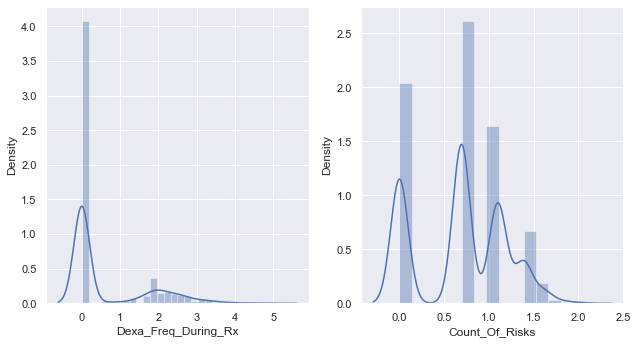

In [113]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['Count_Of_Risks']));

## 1.5.2 Categorical Atributes

In [114]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cat_attributes.apply(lambda x: x.unique().shape[0]))

Ptid                                                                  3424
Persistency_Flag                                                         2
Gender                                                                   2
Race                                                                     4
Ethnicity                                                                3
Region                                                                   5
Age_Bucket                                                               4
Ntm_Speciality                                                          36
Ntm_Specialist_Flag                                                      2
Ntm_Speciality_Bucket                                                    3
Gluco_Record_Prior_Ntm                                                   2
Gluco_Record_During_Rx                                                   2
Dexa_During_Rx                                                           2
Frag_Frac_Prior_Ntm      

# 2.0. STEP 02 - FEATURE ENGINEERING

In [115]:
df2 = df1.copy()

## 2.1. Mind Map Hyphotesis

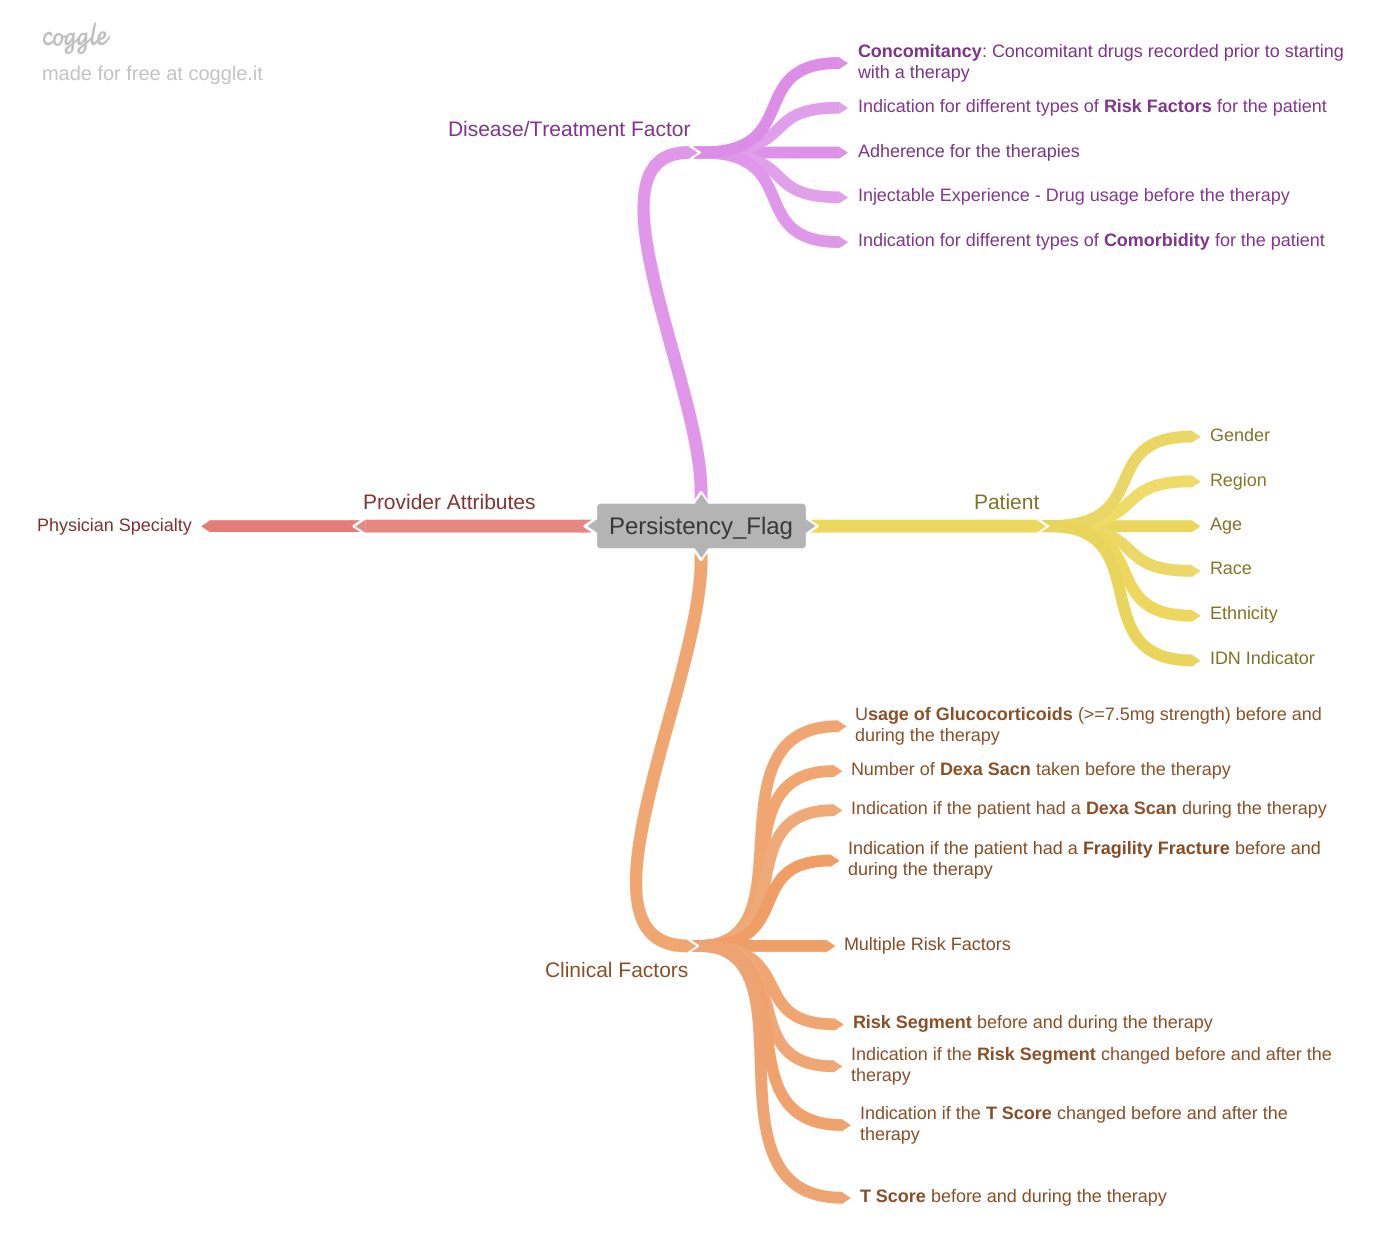

In [116]:
Image('Persistency_Flag.png')

## 2.2. Hyphotesis Creation

### 2.1.1 Patient Hypothesis

**1.** Female patients are more persistent of a drug than male.

**2.** Patients from Northeast are more persistent of a drug than patients from South.

**3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.

**4.** Caucasian patients, not hispanic are more persistent of a drug than patients with different race and ethinicity.

**5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.

### 2.1.2 Povider Attributes Hypothesis

**1.** Patients that received the drug prescription from General Practtitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.

### 2.1.3 Clinical Factors Hypothesis

**1.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid neither had a Fragility Fracture, in any situation.

**2.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan less than 0 times.

**3.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that presents other types of Risk Segment and Change in Risk Segment.

**4.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.

### 2.1.4 Disease/Treatment Factor Hypothesis

**1.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.

**2.** Patients adherent for therapies and that used drugs berofe the therapy are more persistent of a drug than patients in different sutiations related to both attributes.

**3.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that  used more than 2 concomitancy drugsbefore the therapy.

**4.** Patients that presents more than 3 diffetrent types of comorbidity are more persistent of a drug than patients that  presents less than 3 diffetrent types of comorbidity.

## 2.3. Hyphotesis Final List

**1.** Female patients are more persistent of a drug than male.

**2.** Patients from Northeast are more persistent of a drug than patients from South.

**3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.

**4.** Caucasian patients, not hispanic are more persistent of a drug than patients with different race and ethinicity.

**5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.

**6.** Patients that received the drug prescription from General Practtitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.

**7.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid neither had a Fragility Fracture, in any situation.

**8.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan less than 0 times.

**9.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that presents other types of Risk Segment and Change in Risk Segment.

**10.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.

**11.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.

**12.** Patients adherent for therapies and that used drugs berofe the therapy are more persistent of a drug than patients in different sutiations related to both attributes.

**13.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that  used more than 2 concomitancy drugsbefore the therapy.

**14.** Patients that presents more than 3 diffetrent types of comorbidity are more persistent of a drug than patients that  presents less than 3 diffetrent types of comorbidity.

## 2.4. Feature Engineering

In [18]:
# Replacing all values 'Y' (Yes) and 'N' (No) for 1 (Yes) and 0 (No), of all categorical attributes Concomitancy and Comorbidity
data = df2.iloc[:, 25:49].replace('Y', 1).replace('N', 0)

# Count_Of_Concomitancy
df2['Count_Of_Concomitancy'] = data.iloc[:, 14:24].dot(np.ones(data.iloc[:, 14:24].shape[1]))
df2['Count_Of_Concomitancy'] = df2['Count_Of_Concomitancy'].astype(np.int64)

# Count_Of_Comorbidity
df2['Count_Of_Comorbidity'] = data.iloc[:, 0:14].dot(np.ones(data.iloc[:, 0:14].shape[1]))
df2['Count_Of_Comorbidity'] = df2['Count_Of_Comorbidity'].astype(np.int64)   

df2

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,Y,Y,Y,N,Y,Y,N,N,N,Y,N,Y,Y,N,N,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,1,

In [19]:
df2.dtypes

Ptid                     object
Persistency_Flag         object
Gender                   object
Race                     object
Ethnicity                object
                          ...  
Risk_Immobilization      object
Risk_Recurring_Falls     object
Count_Of_Risks            int64
Count_Of_Concomitancy     int64
Count_Of_Comorbidity      int64
Length: 71, dtype: object

# 3.0. STEP 03 - VARIABLES FILTER

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5


## 3.1. Columns Selection

In [22]:
df3[(df3['Dexa_Freq_During_Rx'] == 0) & (df3['Dexa_During_Rx'] == 'Y')].shape

(0, 71)

Because there are no values 'Y' in column 'Dexa_During_Rx' for values 0 in column 'Dexa_Freq_During_Rx', it is assumed 
that all values 0 in column 'Dexa_Freq_During_Rx' are values 'N' in column 'Dexa_During_Rx', and all values above
0 in column 'Dexa_Freq_During_Rx' are 'Y' values in column 'Dexa_During_Rx'. So there is no need to use the 
Dexa_During_Rx' column, so it can be excluded from the dataset.

In [23]:
### Business Restriction for columns:
cols_drop = ['Dexa_During_Rx'] 
df3 = df3.drop(cols_drop, axis=1)

In [24]:
df3.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_Histo

In [25]:
print('Number of Rows: {}'.format(df3.shape[0]))
print('Number of Columns: {}'.format(df3.shape[1]))

Number of Rows: 3424
Number of Columns: 70


# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

Persistency_Flag
Non-Persistent    2135
Persistent        1289
dtype: int64


<AxesSubplot:xlabel='Persistency_Flag', ylabel='count'>

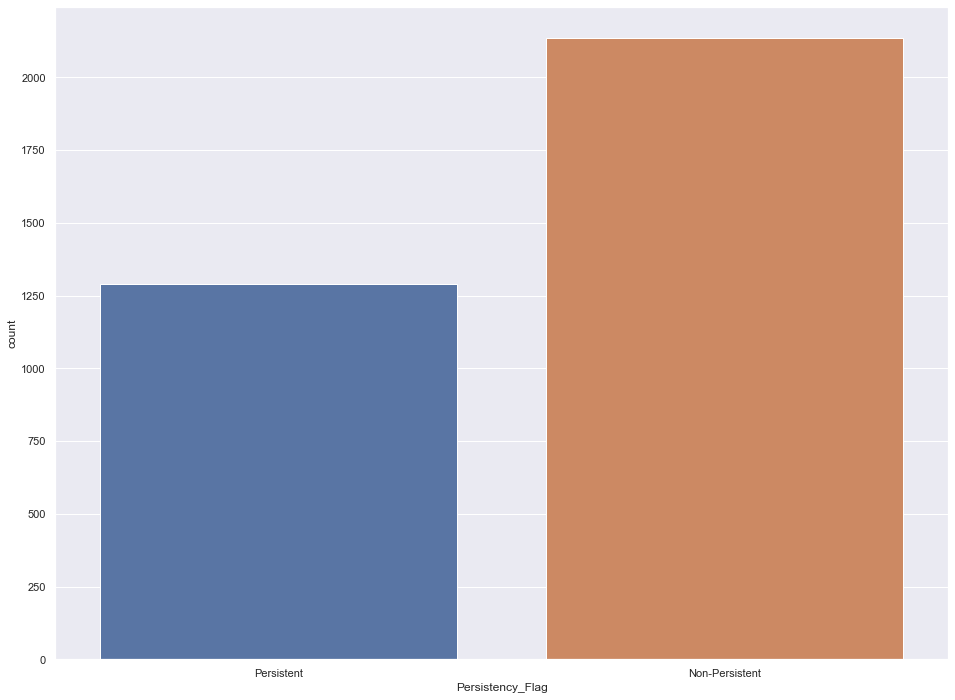

In [27]:
print(df1.value_counts('Persistency_Flag'))
sns.countplot(x="Persistency_Flag",data=df1, dodge=True)

### 4.1.2. Numerical Variable

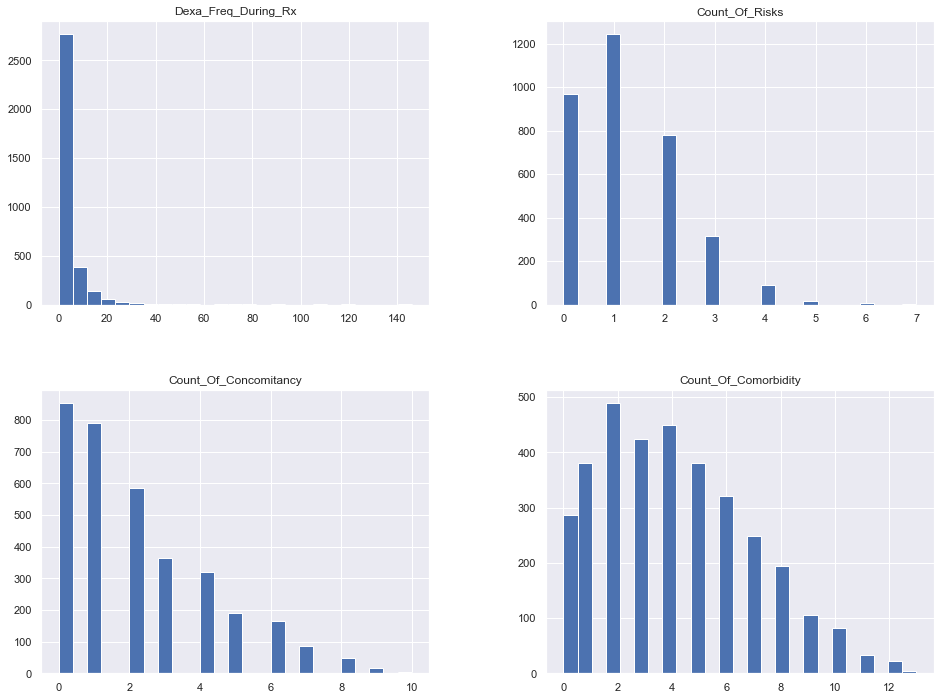

In [28]:
a = df4.select_dtypes(include=['int64', 'float64'])

a.hist(bins = 25);

All numerical attributes show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

All variables show a positive skew, trending to the left. And the variable 'Dexa_Freq_During_Rx' presents a very high kurtosis, because its values are extremely concentrated on the value 0.

### 4.1.3. Categorical Variable

The Categorical Variable will be analyzed in Bivariate Analysis, in the hypothesis tests.

## 4.2. Bivariate Analysis

### H1.** Female patients are more persistent of a drug than male.
**TRUE** There are 1212 female persistent patients and 77 male persistent patients, which means, there are a difference between the genders of 1135 persistent patients.

   Gender Persistency_Flag  Ptid
0  Female   Non-Persistent  2018
1  Female       Persistent  1212
2    Male   Non-Persistent   117
3    Male       Persistent    77


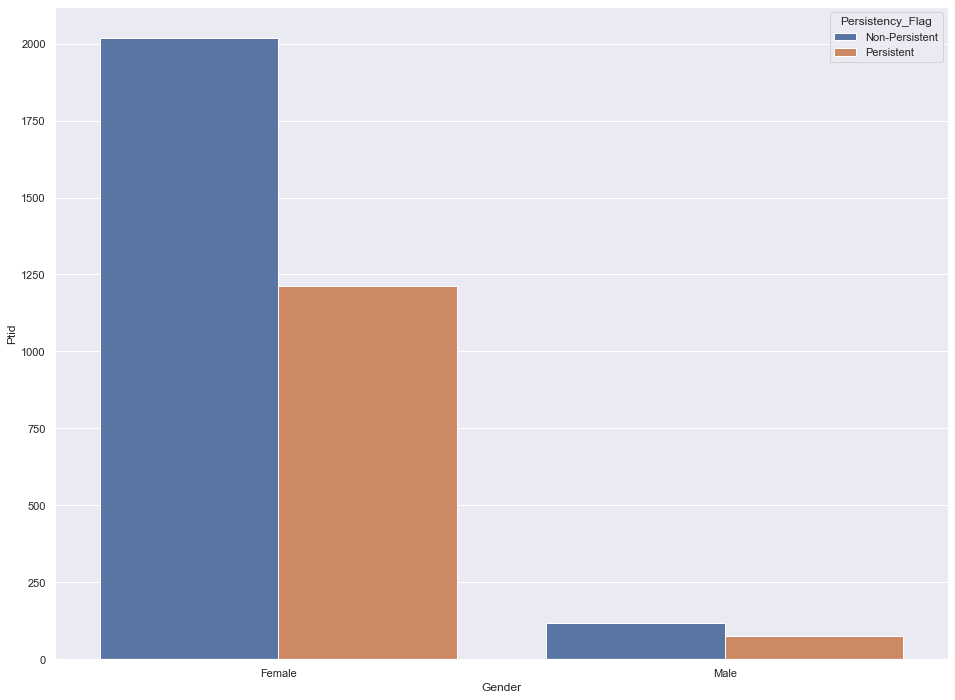

In [28]:
H1 = df4[['Ptid', 'Gender', 'Persistency_Flag']].groupby(['Gender', 'Persistency_Flag']).count().reset_index()
print(H1)

sns.barplot(x = 'Gender', y = 'Ptid', hue = 'Persistency_Flag', data = H1);

The categorical attribute 'Gender' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H2.** Patients from Northeast are more persistent of a drug than patients from South.
**FALSE** There are 98 persistent patients from Northeast and 494 persistent patients from South, which means, there are a difference between the regions of 396 persistent patients.

          Region Persistency_Flag  Ptid
0        Midwest   Non-Persistent   934
1        Midwest       Persistent   449
2      Northeast   Non-Persistent   134
3      Northeast       Persistent    98
4  Other/Unknown   Non-Persistent    35
5  Other/Unknown       Persistent    25
6          South   Non-Persistent   753
7          South       Persistent   494
8           West   Non-Persistent   279
9           West       Persistent   223



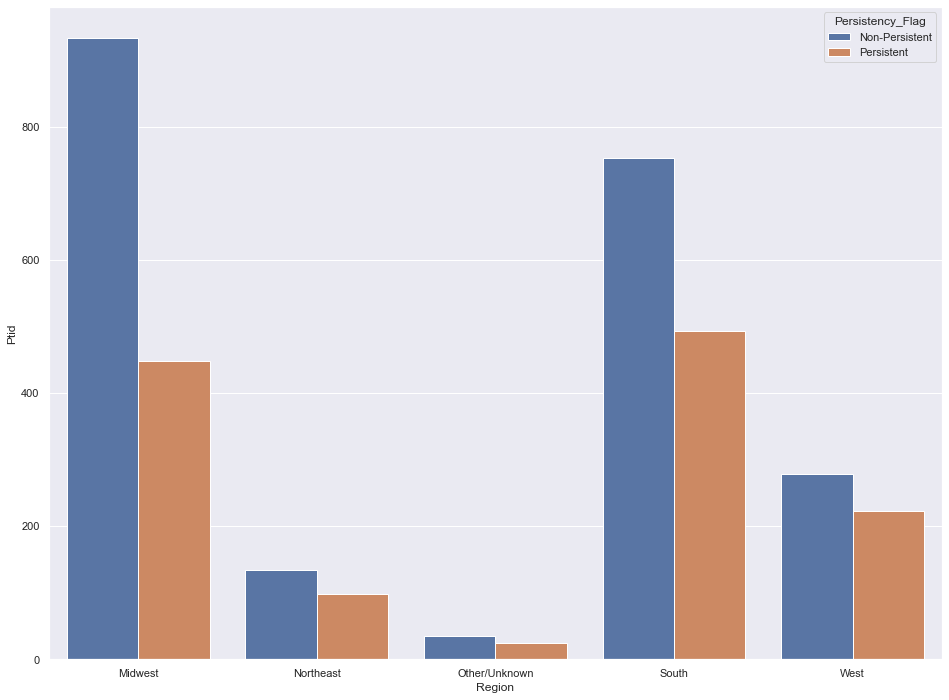

In [138]:
H2 = df4[['Ptid', 'Region', 'Persistency_Flag']].groupby(['Region', 'Persistency_Flag']).count().reset_index()
print(H2, end='\n\n')

sns.barplot(x = 'Region', y = 'Ptid', hue = 'Persistency_Flag', data = H2);

The categorical attribute 'Region' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.
**TRUE** There are 965 persistent patients over 65 of age and 324 persistent patients' young than 65 years of age, which means, there are a difference between the ages of 641 persistent patients.

  Age_Bucket Persistency_Flag  Ptid
0      55-65   Non-Persistent   472
1      55-65       Persistent   261
2      65-75   Non-Persistent   653
3      65-75       Persistent   433
4        <55   Non-Persistent   103
5        <55       Persistent    63
6        >75   Non-Persistent   907
7        >75       Persistent   532

  Age_Over_65 Persistency_Flag  Ptid
0          NO   Non-Persistent   575
1          NO       Persistent   324
2         YES   Non-Persistent  1560
3         YES       Persistent   965


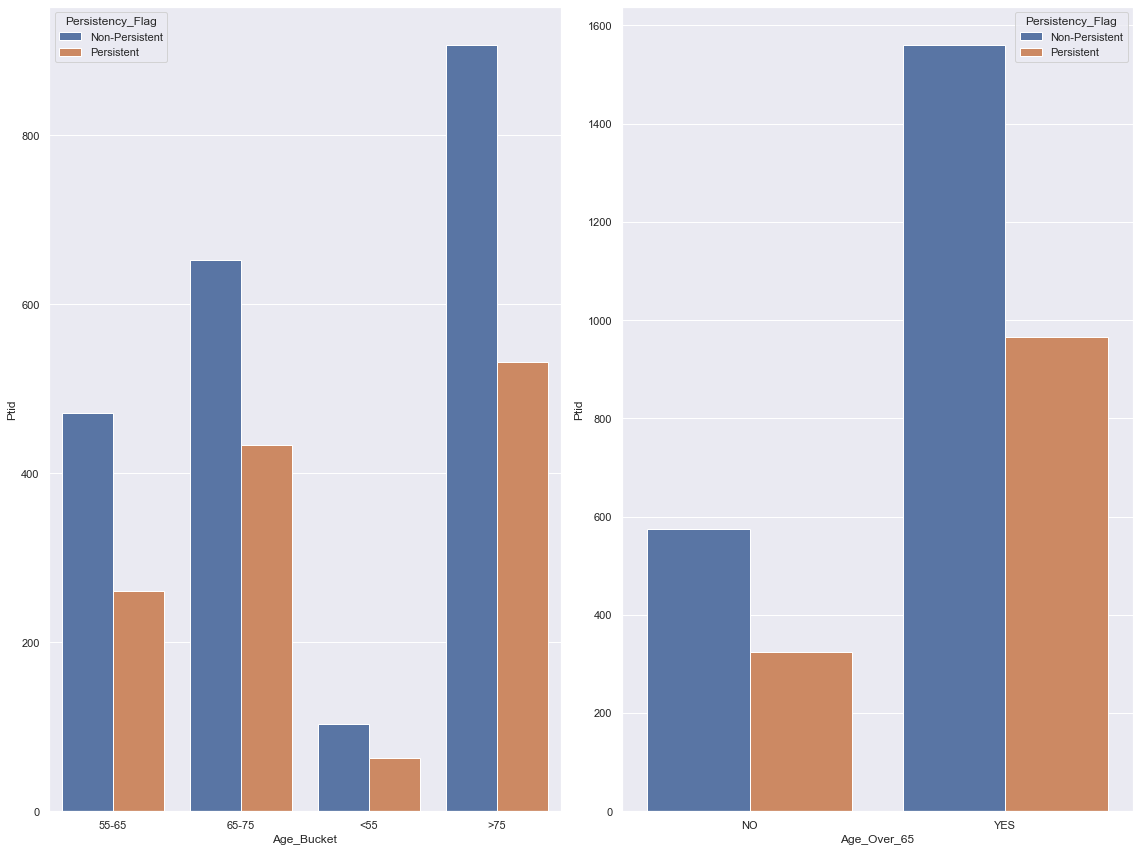

In [162]:
H3 = df4[['Ptid', 'Age_Bucket', 'Persistency_Flag']].groupby(['Age_Bucket', 'Persistency_Flag']).count().reset_index()
print(H3, end='\n\n')

aux_H3 = df4[['Ptid', 'Age_Bucket', 'Persistency_Flag']]      
aux_H3['Age_Over_65'] = aux_H3.apply(lambda x: 'NO' if (x['Age_Bucket'] == '<55') | (x['Age_Bucket'] =='55-65') else
                                           'YES' , axis = 1)
        
H3_1 = aux_H3[['Ptid', 'Age_Over_65', 'Persistency_Flag']].groupby(['Age_Over_65', 'Persistency_Flag']).count().reset_index()
print(H3_1)

plt.subplot(1,2,1)
sns.barplot(x = 'Age_Bucket', y = 'Ptid', hue = 'Persistency_Flag', data = H3);
plt.tight_layout()

plt.subplot(1,2,2)
sns.barplot(x = 'Age_Over_65', y = 'Ptid', hue = 'Persistency_Flag', data = H3_1);
plt.tight_layout()

The categorical attribute 'Age_Bucket' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H4**. Caucasian patients, not Hispanic are more persistent of a drug than patients with different race and ethinicity.
**TRUE** There are 1141 Caucasian Not Hispanic persistent patients and 148 persistent patients from different race and ethnicity, which means, there are a difference between race and ethnicity of 993 persistent patients.

                Race     Ethnicity Persistency_Flag  Ptid
0   African American      Hispanic   Non-Persistent     2
1   African American      Hispanic       Persistent     1
2   African American  Not Hispanic   Non-Persistent    61
3   African American  Not Hispanic       Persistent    29
4   African American       Unknown   Non-Persistent     2
5              Asian      Hispanic   Non-Persistent     1
6              Asian  Not Hispanic   Non-Persistent    41
7              Asian  Not Hispanic       Persistent    41
8              Asian       Unknown   Non-Persistent     1
9          Caucasian      Hispanic   Non-Persistent    40
10         Caucasian      Hispanic       Persistent    20
11         Caucasian  Not Hispanic   Non-Persistent  1882
12         Caucasian  Not Hispanic       Persistent  1141
13         Caucasian       Unknown   Non-Persistent    41
14         Caucasian       Unknown       Persistent    24
15     Other/Unknown      Hispanic   Non-Persistent    23
16     Other/U

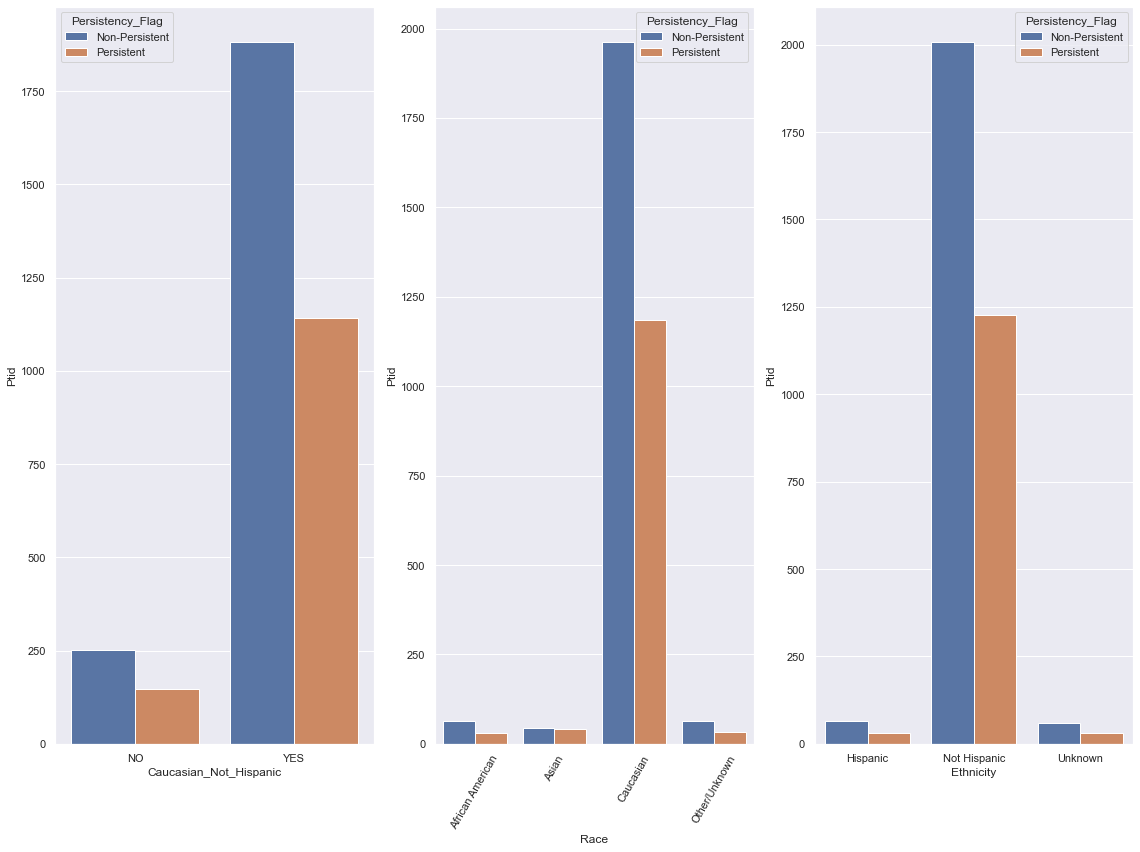

In [165]:
H4 = df4[['Ptid', 'Race', 'Ethnicity', 'Persistency_Flag']].groupby(['Race', 'Ethnicity', 'Persistency_Flag']).count().reset_index()
print(H4, end='\n\n')

aux_H4 = df4[['Ptid', 'Race', 'Ethnicity', 'Persistency_Flag']]       
aux_H4['Caucasian_Not_Hispanic'] = aux_H4.apply(lambda x: 'YES' if (x['Race'] == 'Caucasian') & (x['Ethnicity'] == 'Not Hispanic') else
                                           'NO' , axis = 1)

H4_1 = aux_H4[['Ptid', 'Caucasian_Not_Hispanic', 'Persistency_Flag']].groupby(['Caucasian_Not_Hispanic', 'Persistency_Flag']).count().reset_index()
print(H4_1)

plt.subplot(1,3,1)
sns.barplot(x = 'Caucasian_Not_Hispanic', y = 'Ptid', hue = 'Persistency_Flag', data = H4_1);
plt.tight_layout()

plt.subplot(1,3,2)
H4_2 = df4[['Ptid', 'Race', 'Persistency_Flag']].groupby(['Race', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Race', y = 'Ptid', hue = 'Persistency_Flag', data = H4_2);
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H4_3 = df4[['Ptid', 'Ethnicity', 'Persistency_Flag']].groupby(['Ethnicity', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Ethnicity', y = 'Ptid', hue = 'Persistency_Flag', data = H4_3);
plt.tight_layout()

The categorical attribute 'Race', despite the huge difference between Caucasian to others, does not show a well varied behavior,  not presenting a huge relevance information for the learning of the ML model. 

The categorical attribute 'Ethnicity', dispate the huge differenve between Not Hispanic to others, does not show a well varied behavior,  not presenting a huge relevance information for the learning of the ML model. 

### **H5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.
**TRUE** There are 1043 persistent patients mapped to IDN and 246 persistent patients not mapped to IDN, which means, there are a difference between persistent patients mapped to IDN of 797 patients.

  Idn_Indicator Persistency_Flag  Ptid
0             N   Non-Persistent   621
1             N       Persistent   246
2             Y   Non-Persistent  1514
3             Y       Persistent  1043



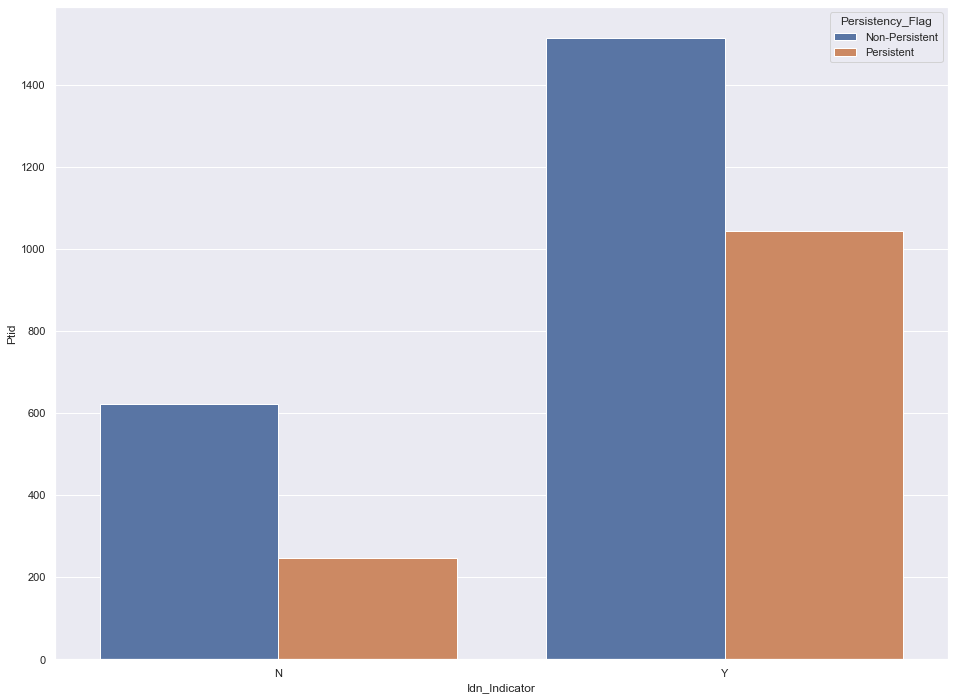

In [142]:
H5 = df4[['Ptid', 'Idn_Indicator', 'Persistency_Flag']].groupby(['Idn_Indicator', 'Persistency_Flag']).count().reset_index()
print(H5, end='\n\n')

sns.barplot(x = 'Idn_Indicator', y = 'Ptid', hue = 'Persistency_Flag', data = H5);

The categorical attribute 'Idn_Indicator' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H6.** Patients that received the drug prescription from General Practitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.
**FALSE** There are 494 persistent patients that received the drug prescription from General Practitioner Specialty and 795 persistent patients that received the drug prescription from others Specialty, there are a difference of 301 persistent patients.

             Speciality Persistency_Flag  Ptid
0  GENERAL PRACTITIONER   Non-Persistent  1041
1  GENERAL PRACTITIONER       Persistent   494
2      OTHER SPECIALITY   Non-Persistent  1094
3      OTHER SPECIALITY       Persistent   795


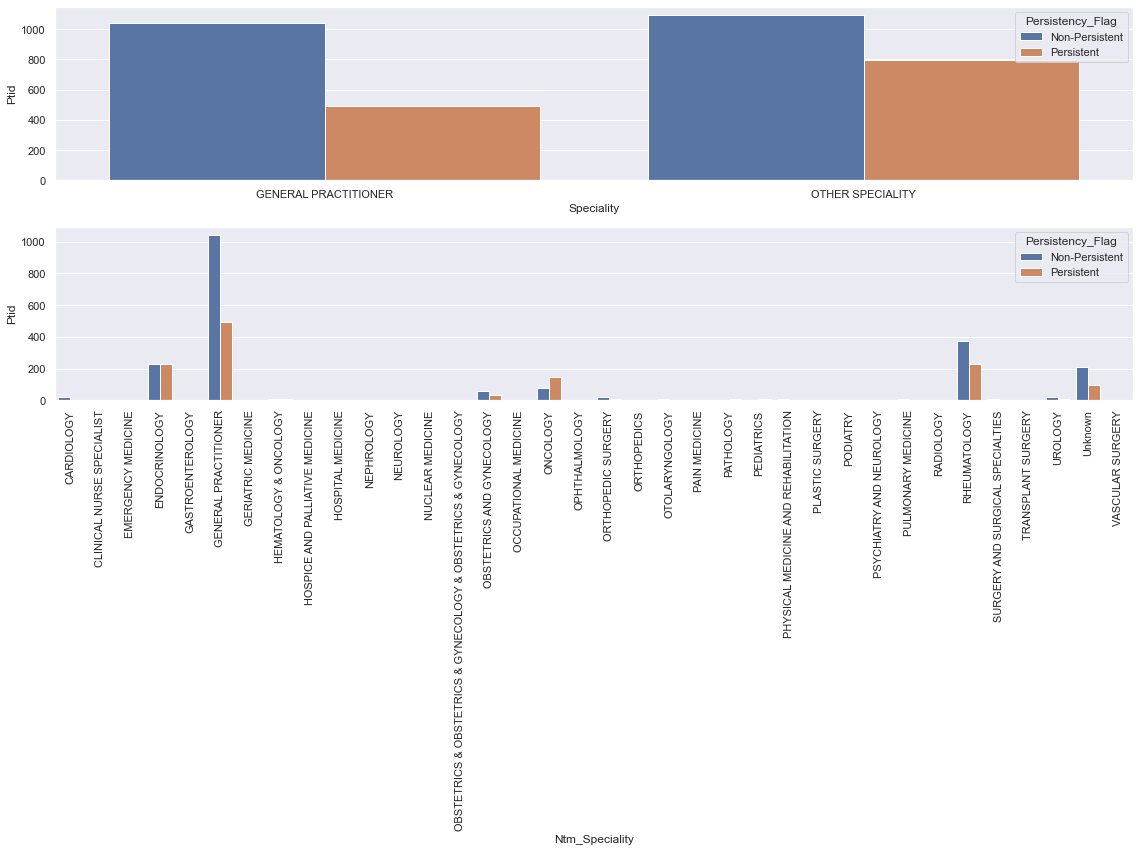

In [201]:
H6 = df4[['Ptid', 'Ntm_Speciality', 'Persistency_Flag']].groupby(['Ntm_Speciality', 'Persistency_Flag']).count().reset_index()

aux_H6 = df4[['Ptid', 'Ntm_Speciality', 'Persistency_Flag']]      
aux_H6['Speciality'] = aux_H6.apply(lambda x: 'OTHER SPECIALITY' if (x['Ntm_Speciality'] != 'GENERAL PRACTITIONER') else
                                              'GENERAL PRACTITIONER' , axis = 1)
    
H6_1 = aux_H6[['Ptid', 'Speciality', 'Persistency_Flag']].groupby(['Speciality', 'Persistency_Flag']).count().reset_index()
print(H6_1)

plt.subplot(2,1,1)
sns.barplot(x = 'Speciality', y = 'Ptid', hue = 'Persistency_Flag', data = H6_1);
plt.tight_layout()

plt.subplot(2,1,2)
sns.barplot(x = 'Ntm_Speciality', y = 'Ptid', hue = 'Persistency_Flag', data = H6);
plt.xticks(rotation=90);
plt.tight_layout()

The categorical attribute 'Ntm_Speciality' does not present a well varied behavior among all speciality except for the general prectioner. Due this fact the variavle do not present a huge relevance information for the learning of the ML model.

### **H7.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid either had a Fragility Fracture, in any situation.
**FALSE** There are 24 persistent patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy and 555 persistent patients that did not use Glucocorticoid neither had a Fragility Fracture, in any situation, which means, there are a difference between both status of 531 persistent patients.

  Glucocorticoid_&_Fragility_Fracture Persistency_Flag  Ptid
0                                ELSE   Non-Persistent   890
1                                ELSE       Persistent   710
2                                  NO   Non-Persistent  1219
3                                  NO       Persistent   555
4                                 YES   Non-Persistent    26
5                                 YES       Persistent    24



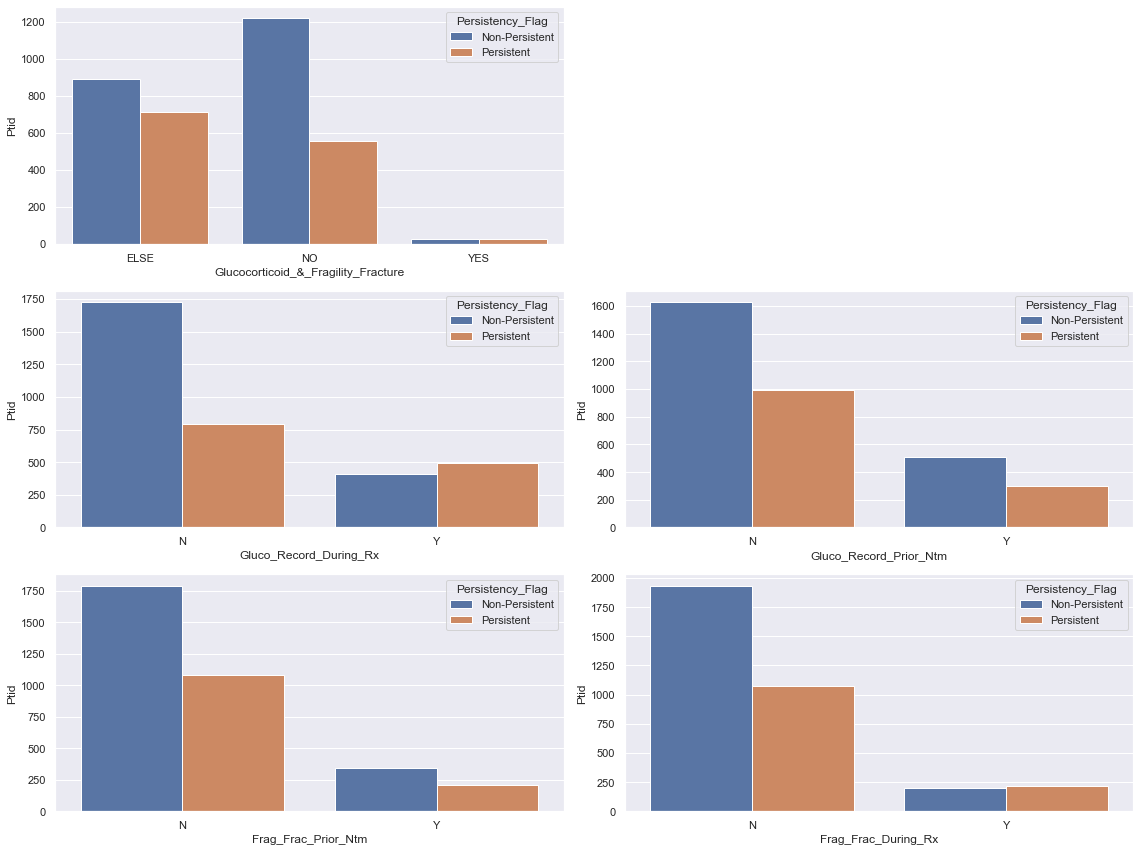

In [188]:
aux_H7 = df4[['Ptid', 'Gluco_Record_During_Rx', 'Gluco_Record_Prior_Ntm', 'Persistency_Flag', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx']]

aux_H7['Glucocorticoid_&_Fragility_Fracture'] = aux_H7.apply(lambda x: 'YES' if (x['Gluco_Record_During_Rx'] == 'Y') & 
                                                                                (x['Gluco_Record_Prior_Ntm'] == 'Y') & 
                                                                                (x['Frag_Frac_Prior_Ntm'] == 'Y') & 
                                                                                (x['Frag_Frac_During_Rx'] == 'Y')      else
                                                                        'NO' if (x['Gluco_Record_During_Rx'] == 'N') & 
                                                                                (x['Gluco_Record_Prior_Ntm'] == 'N') & 
                                                                                (x['Frag_Frac_Prior_Ntm'] == 'N') & 
                                                                                (x['Frag_Frac_During_Rx'] == 'N')      else
                                                                        'ELSE', axis = 1)

H7 = aux_H7[['Ptid', 'Glucocorticoid_&_Fragility_Fracture', 'Persistency_Flag']].groupby(['Glucocorticoid_&_Fragility_Fracture', 'Persistency_Flag']).count().reset_index()
print(H7, end='\n\n')

plt.subplot(3,2,1)
sns.barplot(x = 'Glucocorticoid_&_Fragility_Fracture', y = 'Ptid', hue = 'Persistency_Flag', data = H7);
plt.tight_layout()

plt.subplot(3,2,3)
H7_2 = df4[['Ptid', 'Gluco_Record_During_Rx', 'Persistency_Flag']].groupby(['Gluco_Record_During_Rx', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Gluco_Record_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H7_2);
plt.tight_layout()

plt.subplot(3,2,4)
H7_3 = df4[['Ptid', 'Gluco_Record_Prior_Ntm', 'Persistency_Flag']].groupby(['Gluco_Record_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Gluco_Record_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H7_3);
plt.tight_layout()

plt.subplot(3,2,5)
H7_4 = df4[['Ptid', 'Frag_Frac_Prior_Ntm', 'Persistency_Flag']].groupby(['Frag_Frac_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Frag_Frac_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H7_4);
plt.tight_layout()

plt.subplot(3,2,6)
H7_5 = df4[['Ptid', 'Frag_Frac_During_Rx', 'Persistency_Flag']].groupby(['Frag_Frac_During_Rx', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Frag_Frac_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H7_5);
plt.tight_layout()

All categorical attributes in this hyphotesis show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H8.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan 0 times.
**FALSE** There are 716 persistent patients that had Dexa Scan more than 0 times and 573 persistent patients that had Dexa Scan 0 times, which means, there are a difference between both status of 185 persistent patients.

    Dexa_Freq_During_Rx Persistency_Flag  Ptid
0                     0   Non-Persistent  1915
1                     0       Persistent   573
2                     1   Non-Persistent    24
3                     2   Non-Persistent    24
4                     3   Non-Persistent    23
..                  ...              ...   ...
80                   88       Persistent     1
81                  108       Persistent     1
82                  110   Non-Persistent     1
83                  118       Persistent     1
84                  146       Persistent     1

[85 rows x 3 columns]

  Dexa_Scan_Over_0 Persistency_Flag  Ptid
0               NO   Non-Persistent  1915
1               NO       Persistent   573
2              YES   Non-Persistent   220
3              YES       Persistent   716


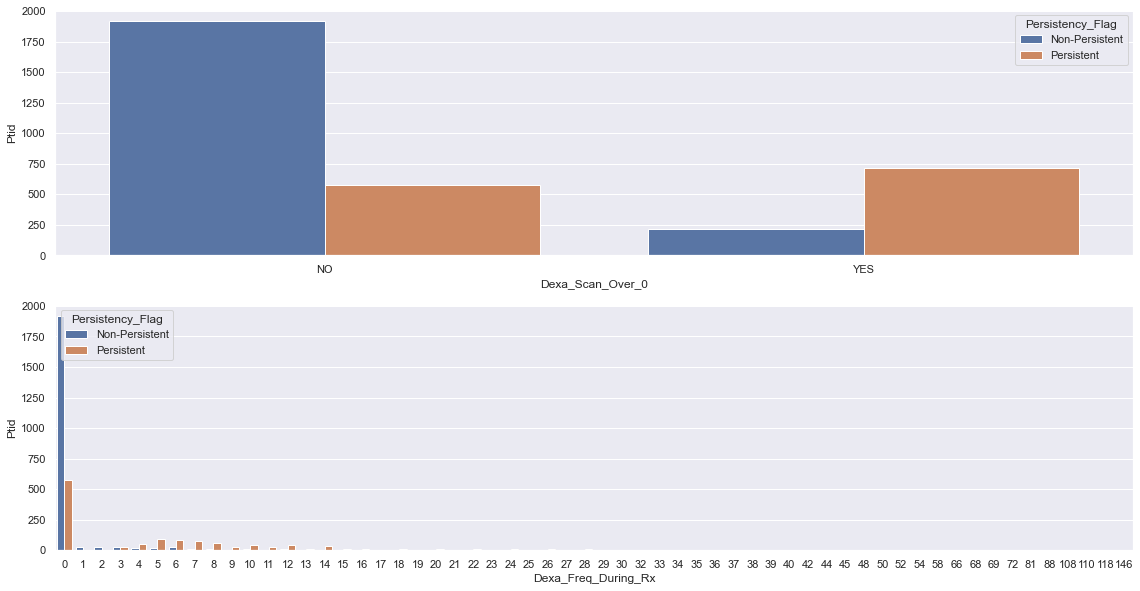

In [209]:
H8 = df4[['Ptid', 'Dexa_Freq_During_Rx', 'Persistency_Flag']].groupby(['Dexa_Freq_During_Rx', 'Persistency_Flag']).count().reset_index()
print(H8, end='\n\n')

aux_H8 = df4[['Ptid', 'Dexa_Freq_During_Rx', 'Persistency_Flag']]      
aux_H8['Dexa_Scan_Over_0'] = aux_H8.apply(lambda x: 'YES' if (x['Dexa_Freq_During_Rx'] > 0) else
                                                    'NO' , axis = 1)
       
H8_1 = aux_H8[['Ptid', 'Dexa_Scan_Over_0', 'Persistency_Flag']].groupby(['Dexa_Scan_Over_0', 'Persistency_Flag']).count().reset_index()
print(H8_1)

plt.subplot(3,1,1)
sns.barplot(x = 'Dexa_Scan_Over_0', y = 'Ptid', hue = 'Persistency_Flag', data = H8_1);
plt.tight_layout()

plt.subplot(3,1,2)
sns.barplot(x = 'Dexa_Freq_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H8);
plt.tight_layout()

The categorical attribute 'Dexa_Freq_During_Rx' does not present a well varied behavior among all times that the scan happened, except for o times. Due this fact the variavle do not present a huge relevance information for the learning of the ML model.

### **H9.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that present other types of Risk Segment and Change in Risk Segment.
**FALSE** There are 324 persistent patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy and 965 persistent patients that presents other types of Risk Segment and Change on Risk Segment, which means, there are a difference between both status of 641 persistent patients.

   Risk_Segment_During_Rx Change_Risk_Segment Persistency_Flag  Ptid
0                  HR_VHR            Improved   Non-Persistent     6
1                  HR_VHR            Improved       Persistent     5
2                  HR_VHR           No change   Non-Persistent   457
3                  HR_VHR           No change       Persistent   327
4                  HR_VHR             Unknown   Non-Persistent    16
5                  HR_VHR             Unknown       Persistent    33
6                  HR_VHR            Worsened   Non-Persistent    48
7                  HR_VHR            Worsened       Persistent    73
8                 Unknown             Unknown   Non-Persistent  1082
9                 Unknown             Unknown       Persistent   415
10                 VLR_LR            Improved   Non-Persistent     3
11                 VLR_LR            Improved       Persistent     8
12                 VLR_LR           No change   Non-Persistent   164
13                 VLR_LR         

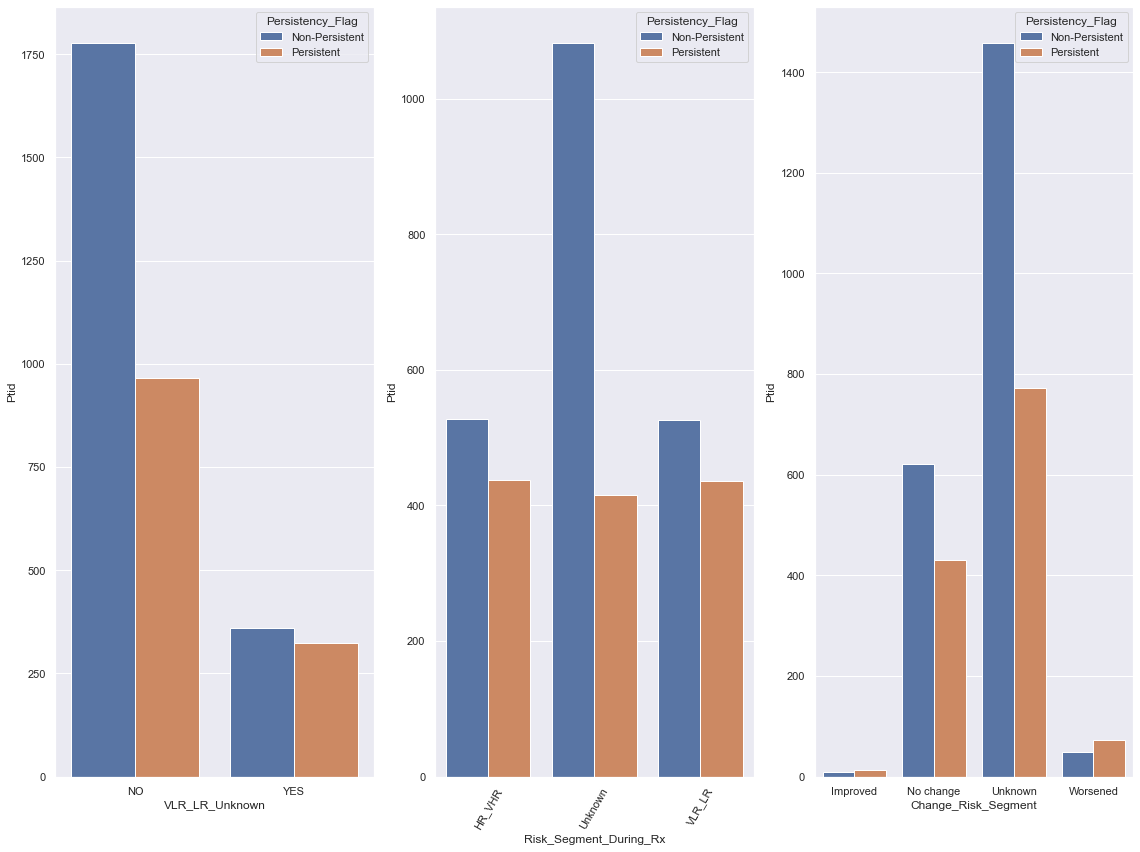

In [38]:
H9 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag']].groupby(['Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag']).count().reset_index()
print(H9, end='\n\n')

aux_H9 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag',]]      
aux_H9['VLR_LR_Unknown'] = aux_H9.apply(lambda x: 'YES' if (x['Risk_Segment_During_Rx'] == 'VLR_LR') & 
                                                            (x['Change_Risk_Segment'] == 'Unknown') else
                                                    'NO' , axis = 1)

H9_1 = aux_H9[['Ptid', 'VLR_LR_Unknown', 'Persistency_Flag']].groupby(['VLR_LR_Unknown', 'Persistency_Flag']).count().reset_index()
print(H9_1)

plt.subplot(1,3,1)
sns.barplot(x = 'VLR_LR_Unknown', y = 'Ptid', hue = 'Persistency_Flag', data = H9_1);
plt.tight_layout()

plt.subplot(1,3,2)
H9_2 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Persistency_Flag']].groupby(['Risk_Segment_During_Rx', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Risk_Segment_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H9_2);
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H9_3 = df4[['Ptid', 'Change_Risk_Segment', 'Persistency_Flag']].groupby(['Change_Risk_Segment', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Change_Risk_Segment', y = 'Ptid', hue = 'Persistency_Flag', data = H9_3);
plt.tight_layout()

The categorical attribute 'Risk_Segment_During_Rx', despite the huge difference between the value Unknown - Non-Persistent to others, dthis attribute does not show a well varied behavior, not presenting a huge relevance information for the learning of the ML model. 

The categorical attribute 'Change_Risk_Segment' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H10.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.
**TRUE** There are 413 persistent patients that presents T Score of >-2.5 before the therapy and presents  No Change T Score status after the therapy and 876 persistent patients that presents other types of T Score and Change on T Score, which means, there are a difference between both status of 463 persistent patients.

   Tscore_Bucket_Prior_Ntm Change_T_Score Persistency_Flag  Ptid
0                   <=-2.5       Improved   Non-Persistent    16
1                   <=-2.5       Improved       Persistent    36
2                   <=-2.5      No change   Non-Persistent   452
3                   <=-2.5      No change       Persistent   288
4                   <=-2.5        Unknown   Non-Persistent   449
5                   <=-2.5        Unknown       Persistent   179
6                   <=-2.5       Worsened   Non-Persistent    17
7                   <=-2.5       Worsened       Persistent    36
8                    >-2.5       Improved   Non-Persistent    12
9                    >-2.5       Improved       Persistent    30
10                   >-2.5      No change   Non-Persistent   507
11                   >-2.5      No change       Persistent   413
12                   >-2.5        Unknown   Non-Persistent   633
13                   >-2.5        Unknown       Persistent   236
14                   >-2.

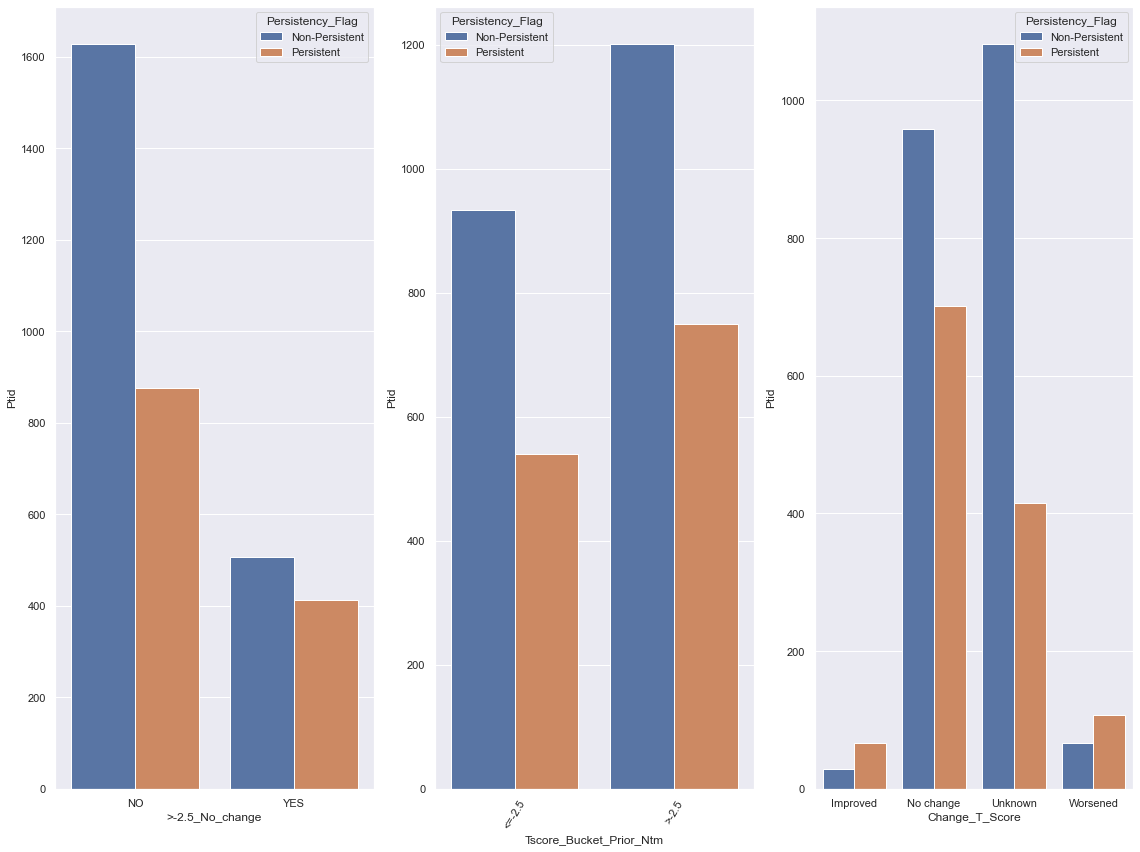

In [42]:
H10 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag']].groupby(['Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag']).count().reset_index()
print(H10, end='\n\n')

aux_H10 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag',]]      
aux_H10['>-2.5_No_change'] = aux_H10.apply(lambda x: 'YES' if (x['Tscore_Bucket_Prior_Ntm'] == '>-2.5') & 
                                                             (x['Change_T_Score'] == 'No change') else
                                                    'NO' , axis = 1)

H10_1 = aux_H10[['Ptid', '>-2.5_No_change', 'Persistency_Flag']].groupby(['>-2.5_No_change', 'Persistency_Flag']).count().reset_index()
print(H10_1)

plt.subplot(1,3,1)
sns.barplot(x = '>-2.5_No_change', y = 'Ptid', hue = 'Persistency_Flag', data = H10_1);
plt.tight_layout()

plt.subplot(1,3,2)
H10_2 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Persistency_Flag']].groupby(['Tscore_Bucket_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Tscore_Bucket_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H10_2);
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H10_3 = df4[['Ptid', 'Change_T_Score', 'Persistency_Flag']].groupby(['Change_T_Score', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Change_T_Score', y = 'Ptid', hue = 'Persistency_Flag', data = H10_3);
plt.tight_layout()

The categorical attribute 'Tscore_Bucket_Prior_Ntm' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

The categorical attribute 'Change_T_Score' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H11.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.
**FALSE** There are 783 persistent patients that do not presents the amount of risk factor higher than 1 and 506 persistent patients that presents the amount of risk factor higher than 1, which means, there are a difference between both status of 277 persistent patients.

    Count_Of_Risks Persistency_Flag  Ptid
0                0   Non-Persistent   658
1                0       Persistent   312
2                1   Non-Persistent   771
3                1       Persistent   471
4                2   Non-Persistent   467
5                2       Persistent   314
6                3   Non-Persistent   179
7                3       Persistent   138
8                4   Non-Persistent    50
9                4       Persistent    41
10               5   Non-Persistent     6
11               5       Persistent     9
12               6   Non-Persistent     3
13               6       Persistent     3
14               7   Non-Persistent     1
15               7       Persistent     1

  Risks_Over_1 Persistency_Flag  Ptid
0           NO   Non-Persistent  1429
1           NO       Persistent   783
2          YES   Non-Persistent   706
3          YES       Persistent   506


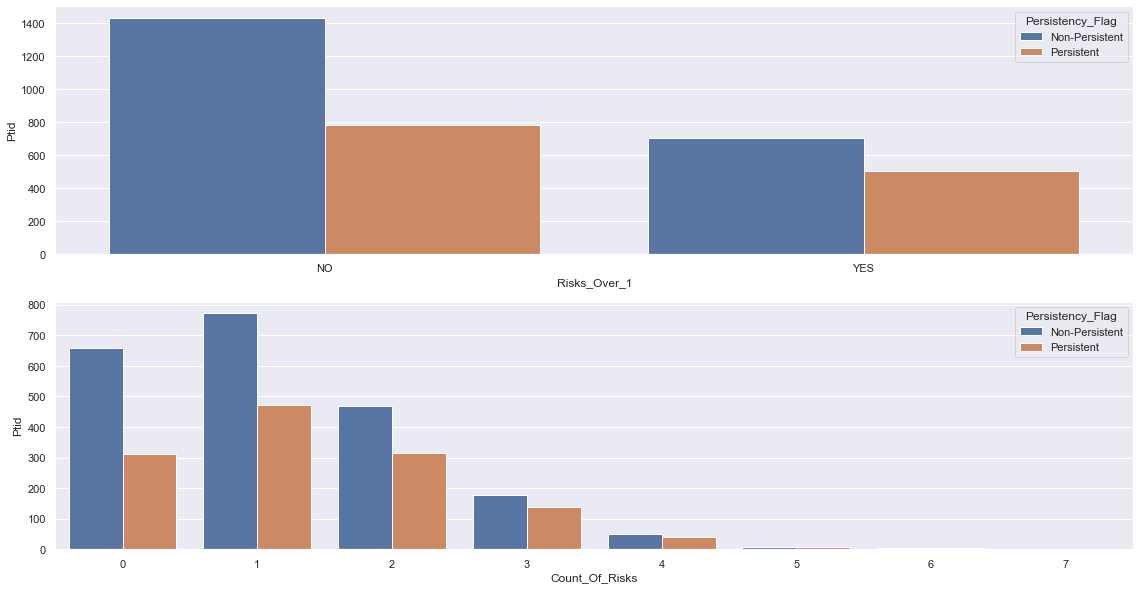

In [215]:
H11 = df4[['Ptid', 'Count_Of_Risks', 'Persistency_Flag']].groupby(['Count_Of_Risks', 'Persistency_Flag']).count().reset_index()
print(H11, end='\n\n')

aux_H11 = df4[['Ptid', 'Count_Of_Risks', 'Persistency_Flag']]      
aux_H11['Risks_Over_1'] = aux_H11.apply(lambda x: 'YES' if (x['Count_Of_Risks'] > 1) else
                                                  'NO' , axis = 1)
      
H11_1 = aux_H11[['Ptid', 'Risks_Over_1', 'Persistency_Flag']].groupby(['Risks_Over_1', 'Persistency_Flag']).count().reset_index()
print(H11_1)

plt.subplot(3,1,1)
sns.barplot(x = 'Risks_Over_1', y = 'Ptid', hue = 'Persistency_Flag', data = H11_1);
plt.tight_layout()

plt.subplot(3,1,2)
sns.barplot(x = 'Count_Of_Risks', y = 'Ptid', hue = 'Persistency_Flag', data = H11);
plt.tight_layout()

The categorical attribute 'Count_Of_Risks' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H12.** Patients adherent for therapies and that used drugs during the therapy are more persistent of a drug than patients in different situations related to both attributes.
**TRUE** There are 1100 persistent patients adherent for therapies and that used drugs before the therapy and 506 persistent patients, which means, there are differences between both status of 189 persistent patients.

  Adherent_Flag Injectable_Experience_During_Rx Persistency_Flag  Ptid
0      Adherent                               N   Non-Persistent   279
1      Adherent                               N       Persistent    83
2      Adherent                               Y   Non-Persistent  1789
3      Adherent                               Y       Persistent  1100
4  Non-Adherent                               N   Non-Persistent     1
5  Non-Adherent                               N       Persistent     5
6  Non-Adherent                               Y   Non-Persistent    66
7  Non-Adherent                               Y       Persistent   101

  Adherent_Yes Persistency_Flag  Ptid
0           NO   Non-Persistent   346
1           NO       Persistent   189
2          YES   Non-Persistent  1789
3          YES       Persistent  1100


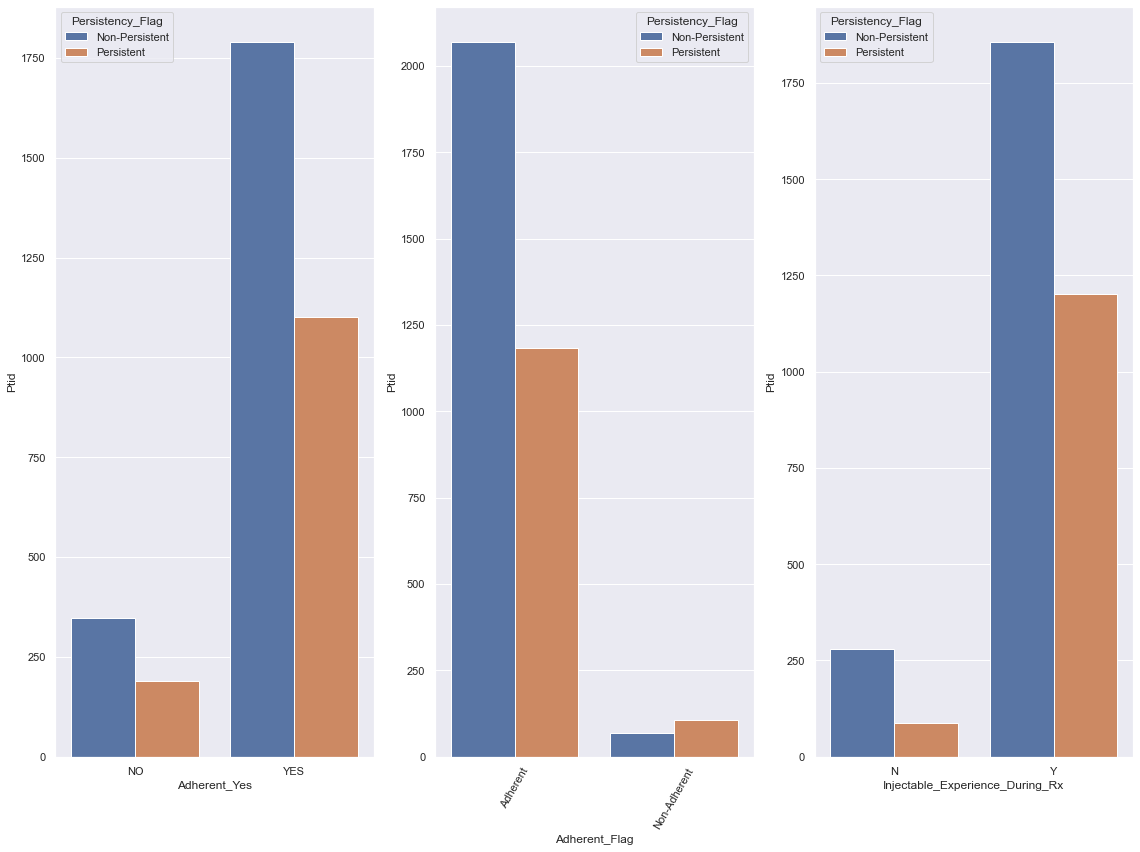

In [47]:
H12 = df4[['Ptid', 'Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag']].groupby(['Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag']).count().reset_index()
print(H12, end='\n\n')

aux_H12 = df4[['Ptid', 'Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag',]]      
aux_H12['Adherent_Yes'] = aux_H12.apply(lambda x: 'YES' if (x['Adherent_Flag'] == 'Adherent') & 
                                                             (x['Injectable_Experience_During_Rx'] == 'Y') else
                                                    'NO' , axis = 1)

H12_1 = aux_H12[['Ptid', 'Adherent_Yes', 'Persistency_Flag']].groupby(['Adherent_Yes', 'Persistency_Flag']).count().reset_index()
print(H12_1)

plt.subplot(1,3,1)
sns.barplot(x = 'Adherent_Yes', y = 'Ptid', hue = 'Persistency_Flag', data = H12_1);
plt.tight_layout()

plt.subplot(1,3,2)
H12_2 = df4[['Ptid', 'Adherent_Flag', 'Persistency_Flag']].groupby(['Adherent_Flag', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Adherent_Flag', y = 'Ptid', hue = 'Persistency_Flag', data = H12_2);
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H12_3 = df4[['Ptid', 'Injectable_Experience_During_Rx', 'Persistency_Flag']].groupby(['Injectable_Experience_During_Rx', 'Persistency_Flag']).count().reset_index()
sns.barplot(x = 'Injectable_Experience_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H12_3);
plt.tight_layout()

The categorical attribute 'Adherent_Flag' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

The categorical attribute 'Injectable_Experience_During_Rx' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H13.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that used more than 2 concomitancy drugs before the therapy.
**FALSE** There are 690 persistent patients that used more than 2 concomitancy drugs before the therapy and 599 persistent patients that used less than 3 concomitancy drugs before the therapy, which means, there are a difference between both status of 91 persistent patients.

    Count_Of_Concomitancy Persistency_Flag  Ptid
0                       0   Non-Persistent   693
1                       0       Persistent   160
2                       1   Non-Persistent   570
3                       1       Persistent   222
4                       2   Non-Persistent   369
5                       2       Persistent   217
6                       3   Non-Persistent   202
7                       3       Persistent   162
8                       4   Non-Persistent   161
9                       4       Persistent   158
10                      5   Non-Persistent    64
11                      5       Persistent   126
12                      6   Non-Persistent    47
13                      6       Persistent   119
14                      7   Non-Persistent    17
15                      7       Persistent    70
16                      8   Non-Persistent     9
17                      8       Persistent    38
18                      9   Non-Persistent     2
19                  

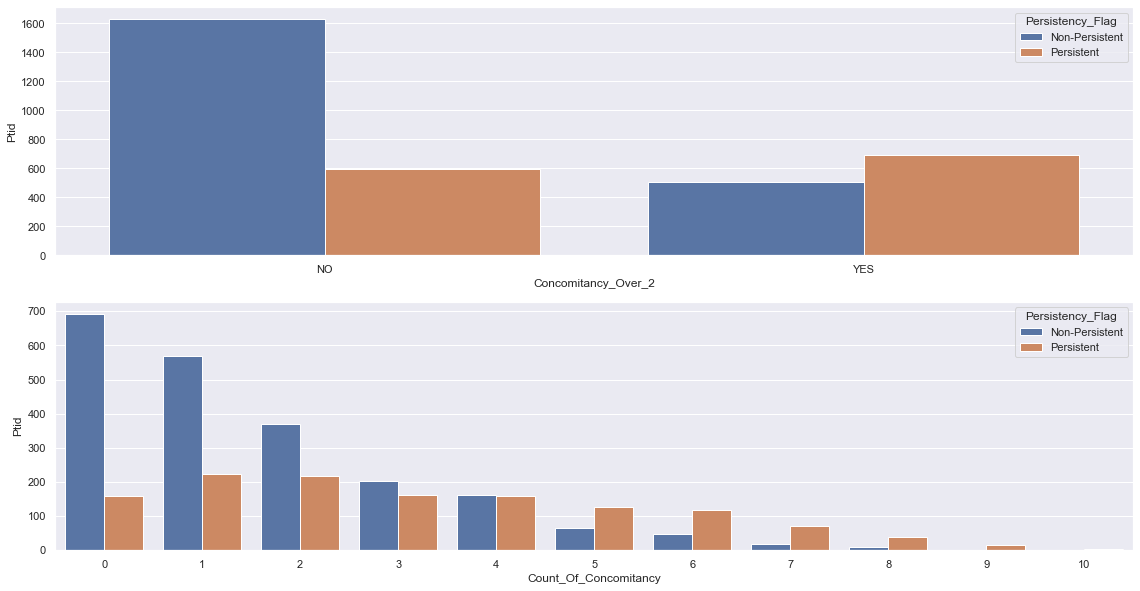

In [223]:
H13 = df4[['Ptid', 'Count_Of_Concomitancy', 'Persistency_Flag']].groupby(['Count_Of_Concomitancy', 'Persistency_Flag']).count().reset_index()
print(H13, end='\n\n')

aux_H13 = df4[['Ptid', 'Count_Of_Concomitancy', 'Persistency_Flag']]      
aux_H13['Concomitancy_Over_2'] = aux_H13.apply(lambda x: 'YES' if (x['Count_Of_Concomitancy'] > 2) else
                                                  'NO' , axis = 1)
      
H13_1 = aux_H13[['Ptid', 'Concomitancy_Over_2', 'Persistency_Flag']].groupby(['Concomitancy_Over_2', 'Persistency_Flag']).count().reset_index()
print(H13_1)

plt.subplot(3,1,1)
sns.barplot(x = 'Concomitancy_Over_2', y = 'Ptid', hue = 'Persistency_Flag', data = H13_1);
plt.tight_layout()

plt.subplot(3,1,2)
sns.barplot(x = 'Count_Of_Concomitancy', y = 'Ptid', hue = 'Persistency_Flag', data = H13);
plt.tight_layout()

The categorical attribute 'Count_Of_Concomitancy' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H14.** Patients that presents more than 3 different types of comorbidity are more persistent of a drug than patients that present less than 3 different types of comorbidity.
**TRUE** There are 1055 persistent patients that presents more than 3 different types of comorbidity and 234 persistent patients that do not presents more than 3 different types of comorbidity, which means, there are a difference between both status of 821 persistent patients.

    Count_Of_Comorbidity Persistency_Flag  Ptid
0                      0   Non-Persistent   268
1                      0       Persistent    19
2                      1   Non-Persistent   335
3                      1       Persistent    45
4                      2   Non-Persistent   410
5                      2       Persistent    79
6                      3   Non-Persistent   333
7                      3       Persistent    91
8                      4   Non-Persistent   299
9                      4       Persistent   151
10                     5   Non-Persistent   205
11                     5       Persistent   176
12                     6   Non-Persistent   133
13                     6       Persistent   188
14                     7   Non-Persistent    87
15                     7       Persistent   161
16                     8   Non-Persistent    35
17                     8       Persistent   160
18                     9   Non-Persistent    18
19                     9       Persisten

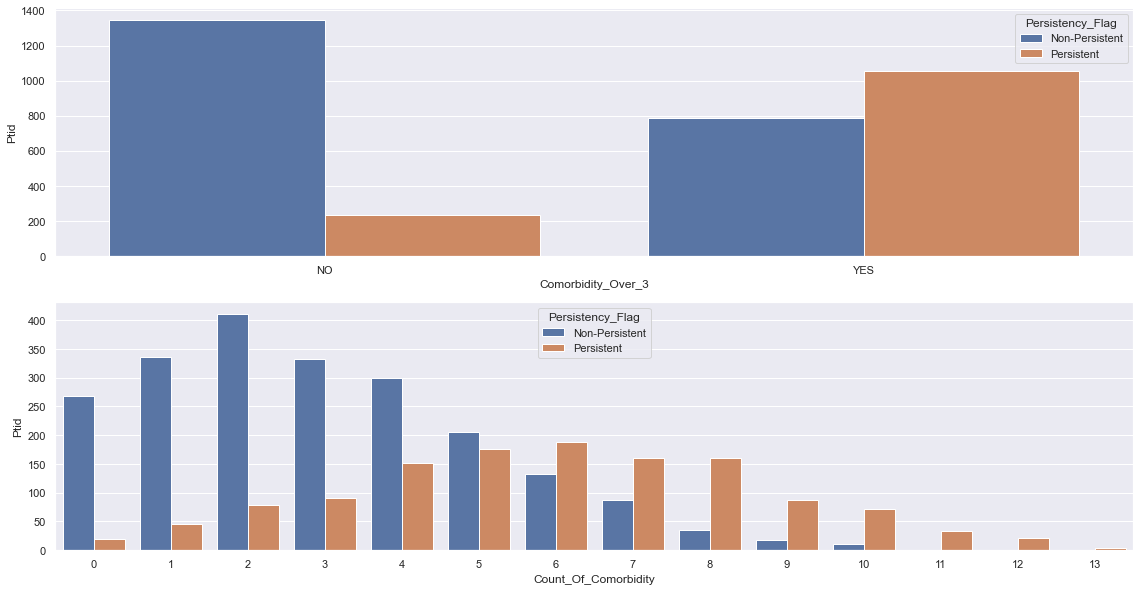

In [229]:
H14 = df4[['Ptid', 'Count_Of_Comorbidity', 'Persistency_Flag']].groupby(['Count_Of_Comorbidity', 'Persistency_Flag']).count().reset_index()
print(H14, end='\n\n')

aux_H14 = df4[['Ptid', 'Count_Of_Comorbidity', 'Persistency_Flag']]      
aux_H14['Comorbidity_Over_3'] = aux_H14.apply(lambda x: 'YES' if (x['Count_Of_Comorbidity'] > 3) else
                                                        'NO' , axis = 1)
      
H14_1 = aux_H14[['Ptid', 'Comorbidity_Over_3', 'Persistency_Flag']].groupby(['Comorbidity_Over_3', 'Persistency_Flag']).count().reset_index()
print(H14_1)

plt.subplot(3,1,1)
sns.barplot(x = 'Comorbidity_Over_3', y = 'Ptid', hue = 'Persistency_Flag', data = H14_1);
plt.tight_layout()

plt.subplot(3,1,2)
sns.barplot(x = 'Count_Of_Comorbidity', y = 'Ptid', hue = 'Persistency_Flag', data = H14);
plt.tight_layout()

The categorical attribute 'Count_Of_Comorbidity' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### 4.2.1. Summary of Hypotheses.

In [29]:
tab = [['Hipoteses', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'High'],
      ['H2', 'False', 'High'],
      ['H3', 'True', 'High'],
      ['H4', 'True', 'Medium/Medium'],
      ['H5', 'True', 'High'],
      ['H6', 'False', 'Medium'],
      ['H7', 'False', 'High'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'Medium/High'],
      ['H10', 'True', 'High/High'],
      ['H11', 'False', 'High'],
      ['H12', 'True', 'High/High'],
      ['H13', 'False', 'High'],
      ['H14', 'True', 'High']]
print(tabulate(tab,headers = 'firstrow'))

Hipoteses    Conclusion    Relevance
-----------  ------------  -------------
H1           True          High
H2           False         High
H3           True          High
H4           True          Medium/Medium
H5           True          High
H6           False         Medium
H7           False         High
H8           False         Medium
H9           False         Medium/High
H10          True          High/High
H11          False         High
H12          True          High/High
H13          False         High
H14          True          High


### 4.2.2. Final Recommendation.

Based on all the Insights created from this dataset, patients who have a higher probability of persisting of a drug for the entire treatment, have the following characteristics:

Female;

Patients older than 65 years;

Caucasian non-Hispanic Patients;

Patients mapped to IDN;

Patients that received the drug prescription from General Practitioner Specialty;

Patients who did not use Glucocorticoid and had Fragility Fracture;

Patients who had no Dexa Scan;

Patient’s adherent for therapies and that used drugs before the therapy.


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

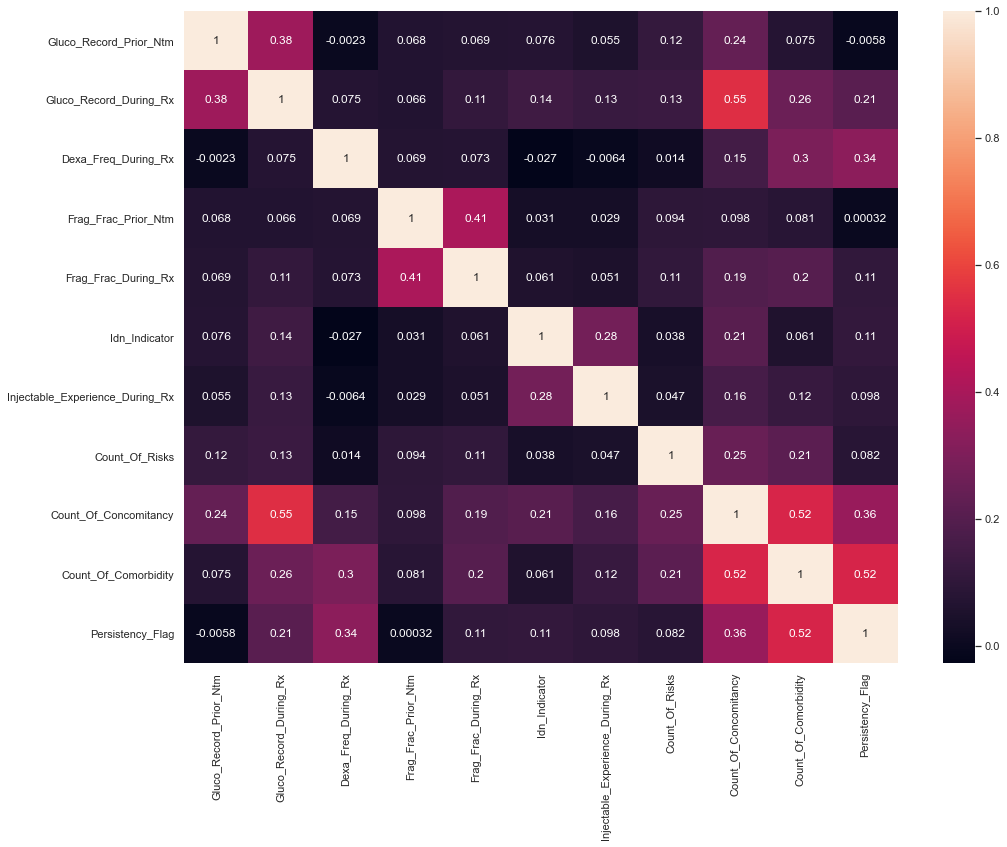

In [30]:
# Replacing all values 'Y' (Yes) and 'N' (No) for 1 (Yes) and 0 (No), of all categorical attributes that has those values.
num_attributes = df4.replace('Y', 1).replace('N', 0)
num_attributes = num_attributes.select_dtypes(include=['int64', 'float64'])
num_attributes['Persistency_Flag'] = df4['Persistency_Flag']
num_attributes['Persistency_Flag'] = num_attributes.apply(lambda x: 1 if (x['Persistency_Flag'] == 'Persistent') else
                                                                    0 , axis = 1)

num_attributes.drop(num_attributes.iloc[:, 7:50], inplace = True, axis = 1)

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# the closer the color black the higher the negative correlation
# the closer the color white the higher the positive correlation

# pearson method only used on numerical variables

In [37]:
cat_attributes = df4.replace('Y', 1).replace('N', 0)
cat_attributes = cat_attributes.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
3420,P3421,Persistent,Female,Caucasian,Not Hispanic,South,>75,Unknown,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Non-Adherent
3421,P3422,Persistent,Female,Caucasian,Not Hispanic,South,>75,ENDOCRINOLOGY,Specialist,Endo/Onc/Uro,VLR_LR,>-2.5,HR_VHR,<=-2.5,No change,Worsened,Adherent
3422,P3423,Non-Persistent,Female,Caucasian,Not Hispanic,South,55-65,Unknown,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent


# 5.0. STEP 05 - DATA PREPARATION

In [95]:
df5 = df4.copy()

## 5.1. Normalization

In [96]:
num_attributes1 = df5.select_dtypes(include=['int64','float64'])

In [97]:
num_attributes1.head()

,Dexa_Freq_During_Rx,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,0,0,0,5
1,0,0,0,1
2,0,2,1,2
3,0,1,3,6
4,0,1,3,5


In [98]:
descriptive_num_attributes(num_attributes1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900
2,Count_Of_Concomitancy,0.000,10.000,10.000,2.175,2.000,2.094,1.010,0.389
3,Count_Of_Comorbidity,0.000,13.000,13.000,4.098,4.000,2.779,0.527,-0.325


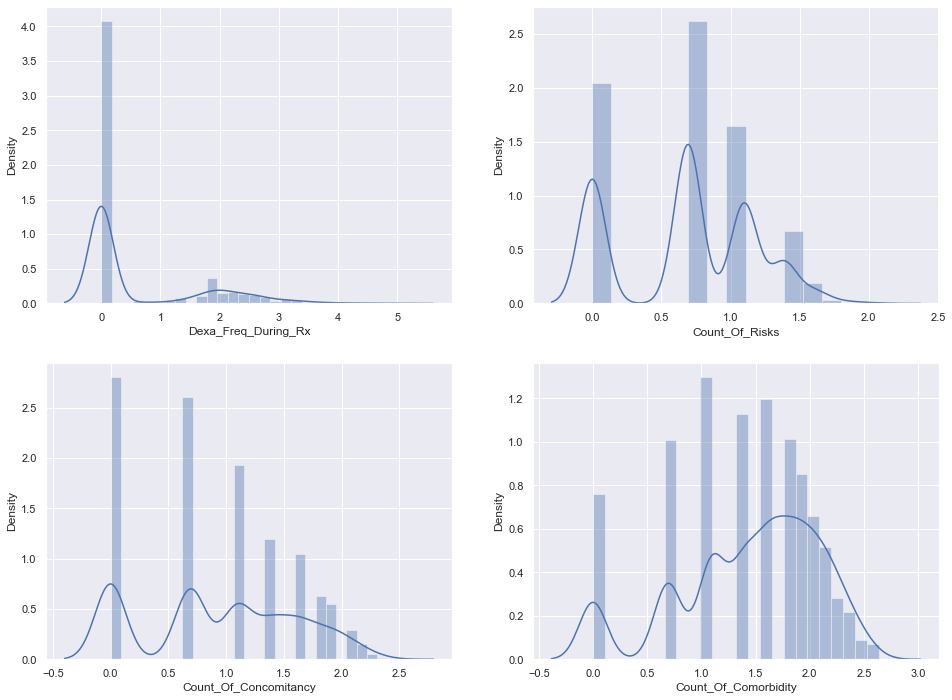

In [99]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,2,1)
sns.distplot(np.log1p(num_attributes1['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,2,2)
sns.distplot(np.log1p(num_attributes1['Count_Of_Risks']));

# 	Count_Of_Concomitancys
plt.subplot(2,2,3)
sns.distplot(np.log1p(num_attributes1['Count_Of_Concomitancy']));

# Count_Of_Risks
plt.subplot(2,2,4)
sns.distplot(np.log1p(num_attributes1['Count_Of_Comorbidity']));

The range of the variable 'Dexa_Freq_During_Rx' is very different from the others variables, wich it can be influenciable on the ML model. 
To solve this it is necessery rescale the variables.

Since there are no numerical variables with normal distribution, normalization is not used then.

## 5.2. Rescaling

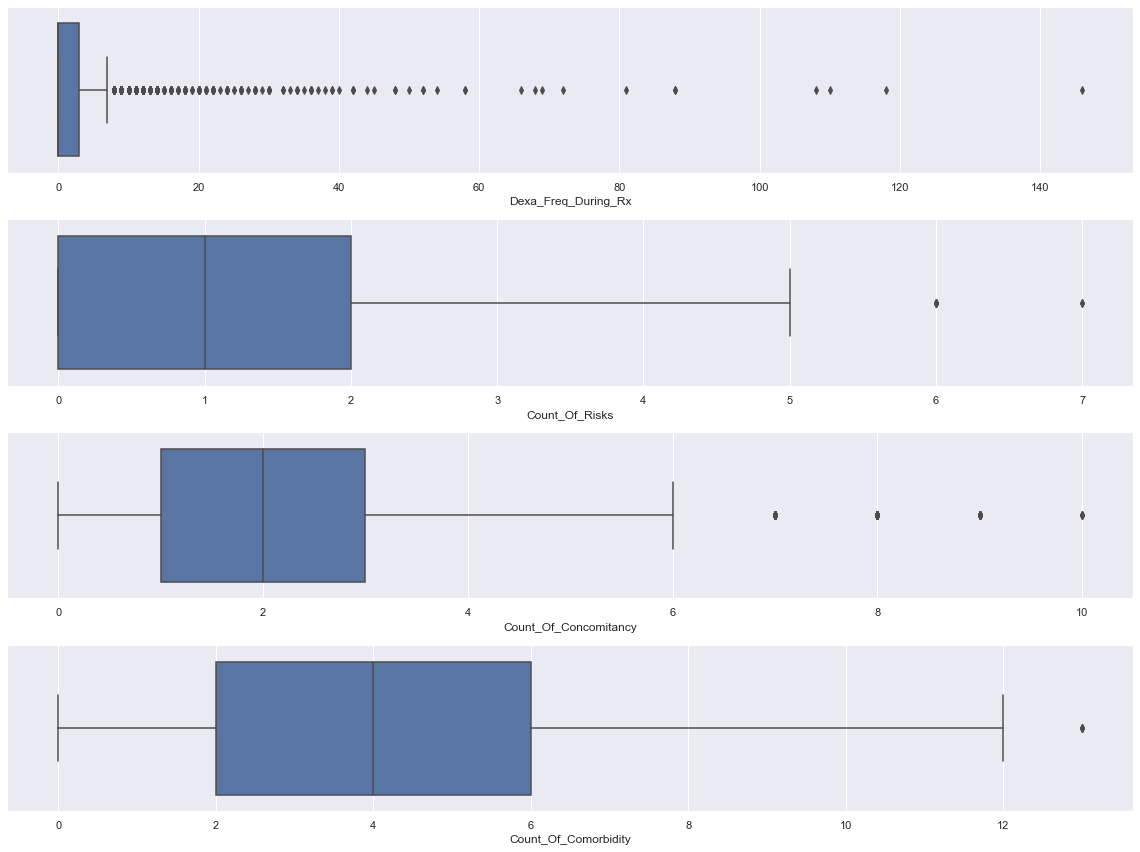

In [101]:
# Dexa_Freq_During_Rx
plt.subplot(4,1,1)
sns.boxplot(df5['Dexa_Freq_During_Rx'])
plt.tight_layout()
# use the robust scaler because it has many outliers

# Count_Of_Risks
plt.subplot(4,1,2)
sns.boxplot(df5['Count_Of_Risks'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Concomitancy
plt.subplot(4,1,3)
sns.boxplot(df5['Count_Of_Concomitancy'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Comorbidity
plt.subplot(4,1,4)
sns.boxplot(df5['Count_Of_Comorbidity'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

In [34]:
# all numerical variables with non-cyclical nature
rs = RobustScaler()
mms = MinMaxScaler()

# Dexa_Freq_During_Rx uses Robust Scaler
df5['Dexa_Freq_During_Rx'] = rs.fit_transform(df5[['Dexa_Freq_During_Rx']].values)
#pickle.dump(rs, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_distance_scaler.pkl', 'wb'))

# Count_Of_Risks uses uses Min-Max Scaler
df5['Count_Of_Risks'] = mms.fit_transform(df5[['Count_Of_Risks']].values)
#pickle.dump(rs, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# Count_Of_Concomitancy uses Min-Max Scaler
df5['Count_Of_Concomitancy'] = mms.fit_transform(df5[['Count_Of_Concomitancy']].values)
#pickle.dump(mms, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# Count_Of_Comorbidity uses Min-Max Scaler
df5['Count_Of_Comorbidity'] = mms.fit_transform(df5[['Count_Of_Comorbidity']].values)
#pickle.dump(mms, open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/year_scaler.pkl', 'wb'))

## 5.3. TRansformation

### 5.3.1. Encoding

In [35]:
b = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
b

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,Y,Y,Y,N,Y,Y,N,N,N,Y,N,Y,Y,N,N,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N
3420,P3421,Persistent,Female,Caucasian,Not Hispanic,South,>75,Unknown,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Non-Adherent

In [36]:
# Categorical Variables

# Categorical attributes that presents binary values as 'Y' and 'N', the method Label Encoding will be used in order to
# transfoer 'Y' and 'N' values into 1 and 0 respectively.

df5 = df5.replace('Y', 1).replace('N', 0)


# Categorical attributes that presents binary values also will be use the method  Label Encoding
le = LabelEncoder()

# Persistency_Flag (Persistent = 1, Non-Persistent = 0)
df5['Persistency_Flag'] = le.fit_transform(df5['Persistency_Flag'])

# Gender (Male = 1, Female = 0)
df5['Gender'] = le.fit_transform(df5['Gender'])

# Ntm_Specialist_Flag (Specialist = 1, Others = 0)
df5['Ntm_Specialist_Flag'] = le.fit_transform(df5['Ntm_Specialist_Flag'])

# Risk_Segment_Prior_Ntm (VLR_LR = 1, HR_VHR = 0)
df5['Risk_Segment_Prior_Ntm'] = le.fit_transform(df5['Risk_Segment_Prior_Ntm'])

# Adherent_Flag (Non-Adherent = 1, Adherent = 0)
df5['Adherent_Flag'] = le.fit_transform(df5['Adherent_Flag'])


# Categorical attributes that presents order or scale will be use the method  Ordinal Encoding

# Age_Bucket
Age_Bucket_dict = {'<55' : 1, '55-65' : 2, '65-75' : 3, '>75' : 4}
df5['Age_Bucket'] = df5['Age_Bucket'].map(Age_Bucket_dict)

# Tscore_Bucket_Prior_Ntm (>-2.5 = 1, <=-2.5 = 0)
Tscore_Bucket_Prior_Ntm_dict = {'<=-2.5' : 1, '>-2.5' : 2}
df5['Tscore_Bucket_Prior_Ntm'] = df5['Tscore_Bucket_Prior_Ntm'].map(Tscore_Bucket_Prior_Ntm_dict)


# Categorical attributes that do not presents order or scale or idea os state, each value is independent, 
# will be use the method  Label Encoding

# Race
df5['Race'] = le.fit_transform(df5['Race'])

# Ethnicity
df5['Ethnicity'] = le.fit_transform(df5['Ethnicity'])

# Region
df5['Region'] = le.fit_transform(df5['Region'])

# Ntm_Speciality_Bucket
df5['Ntm_Speciality_Bucket'] = le.fit_transform(df5['Ntm_Speciality_Bucket'])

# Risk_Segment_During_Rx
df5['Risk_Segment_During_Rx'] = le.fit_transform(df5['Risk_Segment_During_Rx'])

# Tscore_Bucket_During_Rx
df5['Tscore_Bucket_During_Rx'] = le.fit_transform(df5['Tscore_Bucket_During_Rx'])


# Categorical attributes that presents an idea os state, will be use the method  One Hot Encoding

# Change_T_Score
df5 = pd.get_dummies(df5,prefix=['Change_T_Score'], columns=['Change_T_Score'])

# Change_Risk_Segment
df5 = pd.get_dummies(df5,prefix=['Change_Risk_Segment'], columns=['Change_Risk_Segment'])


# Categorical attributes that presents a huge amount of values, will be use the method  Target Encoding
encoder = TargetEncoder()

# Ntm_Speciality
df5['Ntm_Speciality_Encoded'] = encoder.fit_transform(df5['Ntm_Speciality'], df5['Persistency_Flag'])

In [38]:
df5.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Unknown,Change_T_Score_Worsened,Change_Risk_Segment_Improved,Change_Risk_Segment_No change,Change_Risk_Segment_Unknown,Change_Risk_Segment_Worsened,Ntm_Speciality_Encoded
0,P1,1,1,2,1,4,4,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,1,2,2,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.385,0,1,0,0,0,0,1,0,0.322
1,P2,0,1,1,1,4,2,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,1,2,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.077,0,0,1,0,0,0,1,0,0.322
2,P3,0,0,3,0,0,3,GENERAL PRACTITIONER,0,1,0,0,0.000,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.286,0.100,0.154,0,1,0,0,0,1,0,0,0.322
3,P4,0,0,2,1,0,4,GENERAL PRACTITIONER,0,1,0,1,0.000,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.462,0,1,0,0,0,1,0,0,0.322
4,P5,0,0,2,1,0,4,GENERAL PRACTITIONER,0,1,1,1,0.000,0,0,0,1,1,2,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.385,0,0,1,0,0,0,1,0,0.322


# 6.0. STEP 06 - FEATURE SELECTION

In [39]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Training and Test Dataset

In [40]:
# first delete original variables that originated derived variables, they are deleted because they contain the same information
# as the derivatives.

# Attributes to exclude after encoding
cols_drop = ['Ptid', 'Ntm_Speciality']
df6 = df6.drop(cols_drop, axis=1)

In [41]:
# split training and test
X = df6.drop(columns = 'Persistency_Flag', axis = 1)
Y = df6['Persistency_Flag']

## 6.2. Boruta as Feature Selector

In [42]:
# split data 
X_train_n = X.values
Y_train_n = Y.values.ravel()

# define model
extra_model = ExtraTreesClassifier(n_jobs=-1)
# rf = RandomForestClassifier(n_jobs = -1) testar depois

# define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)
#pickle.dump(boruta, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'wb'))
#boruta = pickle.load(open('syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'rb'))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	8
Rejected: 	45
Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	8
Rejected: 	45
Iteration: 	10 / 100
Confirmed: 	21
Tentative: 	8
Rejected: 	45
Iteration: 	11 / 100
Confirmed: 	21
Tentative: 	8
Rejected: 	45
Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	47
Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	6
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	6
Reject

### 6.2.1 Best Features from Boruta

In [43]:
# best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

# select the variables it ranks as most relevant
cols_selected = boruta.support_.tolist() #  show the values of each column, ranking from 1 (most relevant) to 2, 3, 4, etc

# best features 
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list() # showing the name of the columns in the rank

# not selected boruta 
cols_not_selected_boruta = list(np.setdiff1d(X.columns, cols_selected_boruta))

In [44]:
# list of columns selected by boruta
cols_selected_boruta

['Region',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity',
 'Ntm_Speciality_Encoded']

In [45]:
# list of columns not selected by boruta
cols_not_selected_boruta

['Adherent_Flag',
 'Age_Bucket',
 'Change_Risk_Segment_Improved',
 'Change_Risk_Segment_No change',
 'Change_Risk_Segment_Unknown',
 'Change_Risk_Segment_Worsened',
 'Change_T_Score_Improved',
 'Change_T_Score_No change',
 'Change_T_Score_Unknown',
 'Change_T_Score_Worsened',
 'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
 'Comorb_Osteoporosis_without_current_pathological_fracture',
 'Comorb_Personal_history_of_malignant_neoplasm',
 'Concom_Anaesthetics_General',
 'Concom_Anti_Depressants_And_Mood_Stabilisers',
 'Concom_Broad_Spectrum_Penicillins',
 'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations',
 'Concom_Fluoroquinolones',
 'Concom_Narcotics',
 'Count_Of_Risks',
 'Ethnicity',
 'Frag_Frac_During_Rx',
 'Frag_Frac_Prior_Ntm',
 'Gender',
 'Gluco_Record_During_Rx',
 'Gluco_Record_Prior_Ntm',
 'Idn_Indicator',
 'Injectable_Experience_During_Rx',
 'Ntm_Specialist_Flag',
 'Race',
 'Risk_Chronic_Liver_Disease',
 'Risk_Chronic_Malnutrition_Or_Malabsorption',


## 6.3. Manual Feature Selection

In [46]:
cols_selected_boruta = ['Region',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity',
 'Ntm_Speciality_Encoded']

# columns to add
feat_to_add = ['Persistency_Flag']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [47]:
cols_selected_boruta_full

['Region',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity',
 'Ntm_Speciality_Encoded',
 'Persistency_Flag']

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [49]:
df7 = df6[cols_selected_boruta_full].copy()
df7

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,Ntm_Speciality_Encoded,Persistency_Flag
0,4,1,0.000,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0.000,0.385,0.322,1
1,4,1,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.077,0.322,0
2,0,1,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.154,0.322,0
3,0,1,0.000,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0.300,0.462,0.322,0
4,0,1,0.000,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0.300,0.385,0.322,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,3,1,0.000,1,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0.500,0.538,0.322,1
3420,3,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.200,0.000,0.313,1
3421,3,0,2.333,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0.300,0.308,0.496,1
3422,3,1,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.200,0.154,0.313,0


In [50]:
df7.value_counts('Persistency_Flag')

Persistency_Flag
0    2135
1    1289
dtype: int64

### 7.0.1 Spliting Dataset into Target Variablen (y) and Features (X)

In [51]:
# target variable and features split 
X = df7.drop(columns = 'Persistency_Flag', axis = 1)
y = df7['Persistency_Flag']

In [52]:
# Numer of rows before dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(3424, 21)

(3424,)


In [53]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' before dataset balanced
np.bincount(y)

array([2135, 1289], dtype=int64)

### 7.0.2 Balancing Dataset

In [54]:
nr = NearMiss()

In [55]:
X, y = nr.fit_resample(X, y)

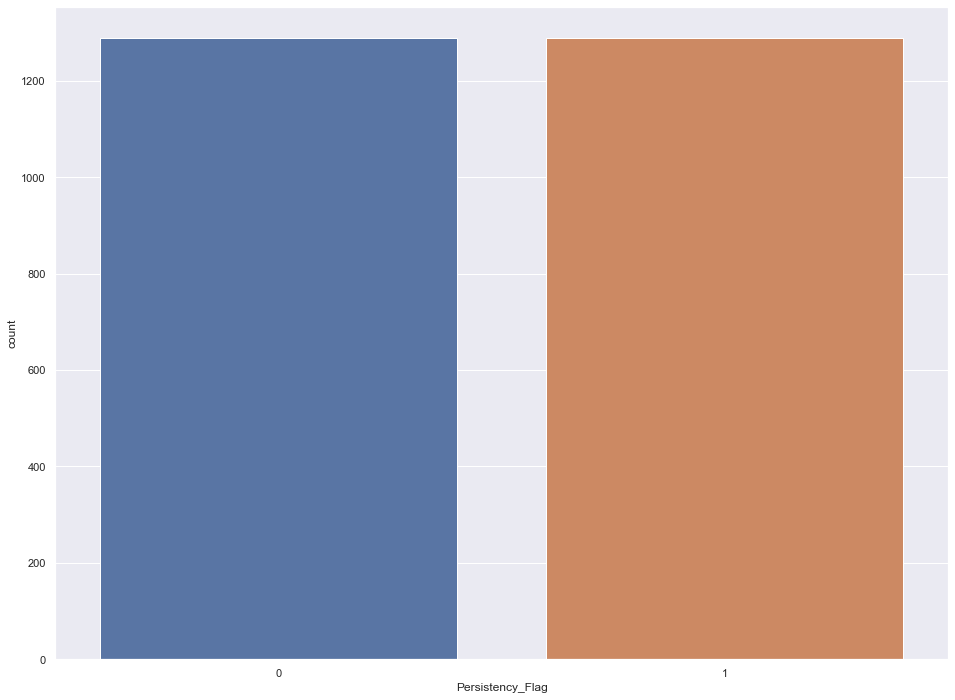

In [56]:
ax = sns.countplot(x=y)

In [57]:
# Numer of rows after dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(2578, 21)

(2578,)


In [58]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced
np.bincount(y)

array([1289, 1289], dtype=int64)

### 7.0.3 Spliting Dataset into Train and Test

In [59]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [60]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced, for y_train
np.bincount(y_train)

array([911, 893], dtype=int64)

In [61]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced, for y_test
np.bincount(y_test)

array([378, 396], dtype=int64)

## 7.1. Logistic Regression Model

In [62]:
# model
lr = LogisticRegression(solver='lbfgs')

# train_model
lr.fit(X_train.values, y_train.values)

# prediction
yhat_lr = lr.predict(X_test)

#performance
result_lr = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_lr),
                            cohen_kappa_score(y_test,yhat_lr),
                            recall_score(y_test,yhat_lr), 
                            f1_score(y_test,yhat_lr),
                            precision_score(y_test,yhat_lr)]).T
result_lr.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_lr))

result_lr

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       378
           1       0.93      0.84      0.88       396

    accuracy                           0.89       774
   macro avg       0.89      0.89      0.89       774
weighted avg       0.89      0.89      0.89       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Logistic Regression,0.888,0.776,0.843,0.885,0.930


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

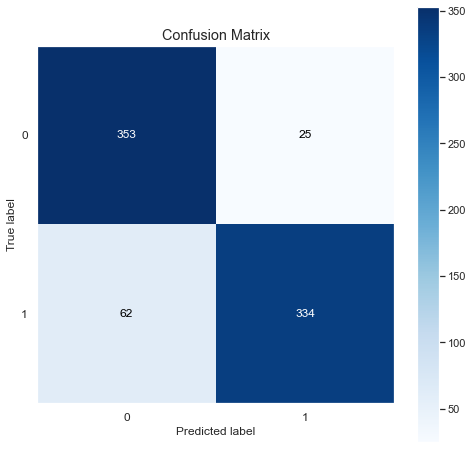

In [63]:
mt.plot_confusion_matrix(y_test, yhat_lr, normalize = False, figsize = (8,8))

### 7.1.1.  Logistic Regression Model - Cross - Validation

In [64]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
lr_cv = cross_validate(lr, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_lr = pd.DataFrame({'Model Name': ["Logistic Regression"],
                                     'Average Accuracy CV' : [np.round(np.mean(lr_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(lr_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(lr_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(lr_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(lr_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(lr_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(lr_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(lr_cv['test_precision']),6).astype(str)]})


cv_result_lr

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Logistic Regression,0.8825 +/- 0.023488,0.8366 +/- 0.049151,0.8752 +/- 0.026445,0.9202 +/- 0.031474


## 7.2. Extra Trees Classifier Model

In [65]:
# model
et = ExtraTreesClassifier(n_jobs=-1, random_state = 42)

# train_model
et.fit(X_train.values, y_train.values)

# prediction
yhat_et = et.predict(X_test)

# performance
result_et = pd.DataFrame(["Extra Trees Classifier",accuracy_score(y_test,yhat_et),
                            cohen_kappa_score(y_test,yhat_et),
                            recall_score(y_test,yhat_et), 
                            f1_score(y_test,yhat_et),
                            precision_score(y_test,yhat_et)]).T
result_et.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_et))

result_et

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       378
           1       0.88      0.83      0.85       396

    accuracy                           0.85       774
   macro avg       0.85      0.85      0.85       774
weighted avg       0.86      0.85      0.85       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Extra Trees Classifier,0.854,0.708,0.831,0.853,0.877


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

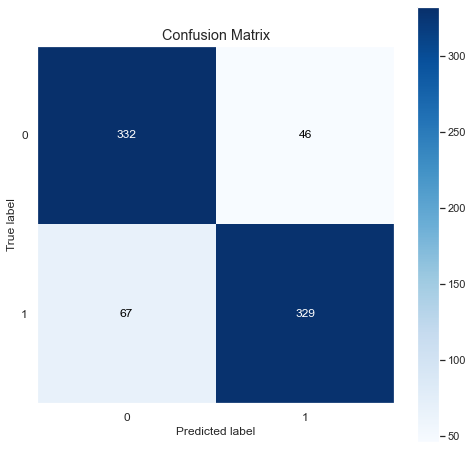

In [66]:
mt.plot_confusion_matrix(y_test, yhat_et, normalize = False, figsize = (8,8))

### 7.2.1 Extra Trees Classifier Model - Cross - Validation

In [67]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
et_cv = cross_validate(et, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_et = pd.DataFrame({'Model Name': ["Extra Trees Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(et_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(et_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(et_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(et_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_precision']),6).astype(str)]})


cv_result_et

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Extra Trees Classifier,0.8537 +/- 0.02245,0.8309 +/- 0.030012,0.849 +/- 0.022238,0.8693 +/- 0.034975


## 7.3. LGBM Classifier Model

In [68]:
# model
lgbm = LGBMClassifier(n_jobs = -1)

# train_model
lgbm.fit(X_train.values, y_train.values)

# prediction
yhat_lgbm = lgbm.predict(X_test)

# performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),
                            cohen_kappa_score(y_test,yhat_lgbm),
                            recall_score(y_test,yhat_lgbm), 
                            f1_score(y_test,yhat_lgbm),
                            precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_lgbm))

result_lgbm

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       378
           1       0.91      0.83      0.87       396

    accuracy                           0.87       774
   macro avg       0.87      0.87      0.87       774
weighted avg       0.87      0.87      0.87       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,LGBM Classifier,0.871,0.742,0.826,0.867,0.913


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

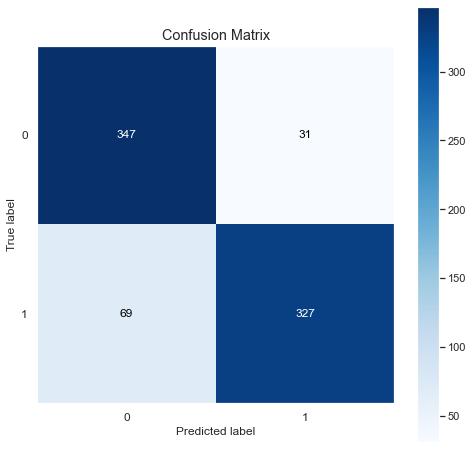

In [69]:
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (8,8))

### 7.3.1 LGBM Classifier Model - Cross - Validation

In [70]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
lgbm_cv = cross_validate(lgbm, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_lgbm = pd.DataFrame({'Model Name': ["LGBM Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(lgbm_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(lgbm_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(lgbm_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(lgbm_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_precision']),6).astype(str)]})


cv_result_lgbm

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,LGBM Classifier,0.8692 +/- 0.026448,0.8388 +/- 0.047351,0.8635 +/- 0.02891,0.8918 +/- 0.03262


## 7.4. Stochastic Gradient Descent Model

In [71]:
# model
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state = 42)

 #train_model
sgd.fit(X_train.values, y_train.values)

# prediction
yhat_sgd = sgd.predict(X_test)

# performance
result_sgd = pd.DataFrame(["SGD Classifier",accuracy_score(y_test,yhat_sgd),
                            cohen_kappa_score(y_test,yhat_sgd),
                            recall_score(y_test,yhat_sgd), 
                            f1_score(y_test,yhat_sgd),
                            precision_score(y_test,yhat_sgd)]).T
result_sgd.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_sgd))

result_sgd

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       378
           1       0.78      0.94      0.85       396

    accuracy                           0.83       774
   macro avg       0.85      0.83      0.83       774
weighted avg       0.85      0.83      0.83       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,SGD Classifier,0.831,0.660,0.937,0.850,0.778


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

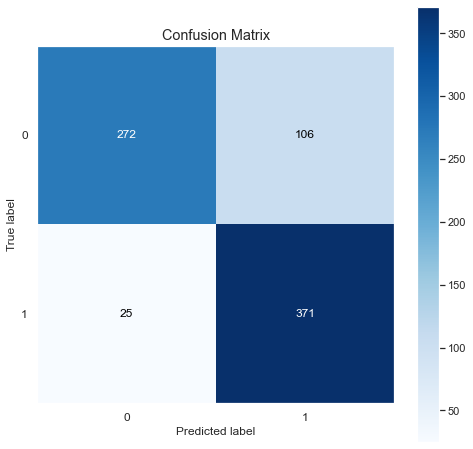

In [72]:
mt.plot_confusion_matrix(y_test, yhat_sgd, normalize = False, figsize = (8,8))

### 7.4.1 Stochastic Gradient Descent Model - Cross - Validation

In [73]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
sgd_cv = cross_validate(sgd, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_sgd = pd.DataFrame({'Model Name': ["SGD Classifie"],
                                     'Average Accuracy CV' : [np.round(np.mean(sgd_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(sgd_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(sgd_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(sgd_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_precision']),6).astype(str)]})


cv_result_sgd

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,SGD Classifie,0.8614 +/- 0.04619,0.8692 +/- 0.050684,0.8626 +/- 0.037073,0.8628 +/- 0.072983


## 7.5. Random Forest Classifier Model

In [74]:
# model
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)

# train_model
rf.fit(X_train.values, y_train.values)

# prediction
yhat_rf = rf.predict(X_test)

# performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),
                            cohen_kappa_score(y_test,yhat_rf),
                            recall_score(y_test,yhat_rf), 
                            f1_score(y_test,yhat_rf),
                            precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_rf))

result_rf

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       378
           1       0.90      0.85      0.87       396

    accuracy                           0.87       774
   macro avg       0.87      0.87      0.87       774
weighted avg       0.87      0.87      0.87       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.872,0.744,0.846,0.871,0.898


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

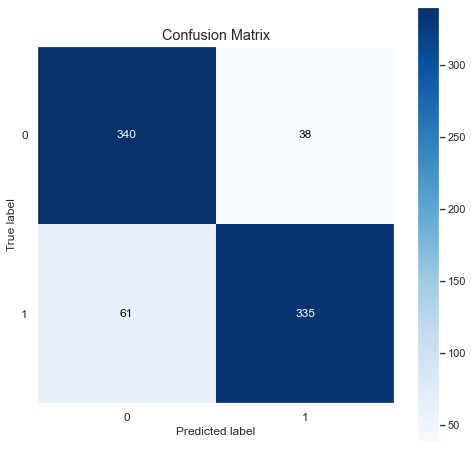

In [75]:
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (8,8))

### 7.5.1 Random Forest Classifier Model - Cross - Validation

In [76]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
rf_cv = cross_validate(rf, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_rf = pd.DataFrame({'Model Name': ["Random Forest Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(rf_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(rf_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(rf_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(rf_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_precision']),6).astype(str)]})


cv_result_rf

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Random Forest Classifier,0.867 +/- 0.02376,0.8444 +/- 0.044458,0.8624 +/- 0.026444,0.8832 +/- 0.032761


## 7.6. Support Vector Machine Model

In [77]:
# model
svm = SVC(kernel='rbf')

# train_model
svm.fit(X_train.values, y_train.values)

# prediction
yhat_svm = svm.predict(X_test)

# performance
result_svm = pd.DataFrame(["Support Vector Machine",accuracy_score(y_test,yhat_svm),
                            cohen_kappa_score(y_test,yhat_svm),
                            recall_score(y_test,yhat_svm), 
                            f1_score(y_test,yhat_svm),
                            precision_score(y_test,yhat_svm)]).T
result_svm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_svm))

result_svm

              precision    recall  f1-score   support

           0       0.84      0.94      0.88       378
           1       0.93      0.83      0.88       396

    accuracy                           0.88       774
   macro avg       0.88      0.88      0.88       774
weighted avg       0.89      0.88      0.88       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Support Vector Machine,0.880,0.760,0.826,0.876,0.932


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

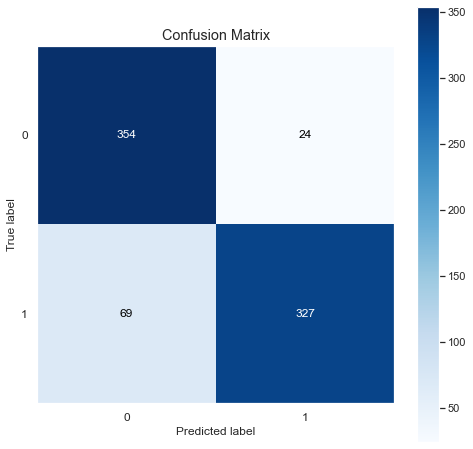

In [78]:
mt.plot_confusion_matrix(y_test, yhat_svm, normalize = False, figsize = (8,8))

### 7.6.1 Support Vector Machine Model - Cross - Validation

In [79]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
svm_cv = cross_validate(svm, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_svm = pd.DataFrame({'Model Name': ["Support Vector Machine"],
                                     'Average Accuracy CV' : [np.round(np.mean(svm_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(svm_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(svm_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(svm_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_precision']),6).astype(str)]})


cv_result_svm

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.8864 +/- 0.026828,0.8389 +/- 0.052798,0.879 +/- 0.030355,0.9255 +/- 0.026914


## 7.7. Compare Model's Performance

In [80]:
#concat each performance as a dataframe
performance = pd.concat([result_lr, result_et, result_lgbm, result_sgd, result_rf, result_svm])
performance.sort_values('Accuracy', ascending = False)
# boruta 21

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Logistic Regression,0.888,0.776,0.843,0.885,0.930
0,Support Vector Machine,0.880,0.760,0.826,0.876,0.932
0,Random Forest Classifier,0.872,0.744,0.846,0.871,0.898
0,LGBM Classifier,0.871,0.742,0.826,0.867,0.913
0,Extra Trees Classifier,0.854,0.708,0.831,0.853,0.877
0,SGD Classifier,0.831,0.660,0.937,0.850,0.778


### 7.7.1 Real Performance - Cross Validation

In [81]:
real_performance_cv = pd.concat([cv_result_lr, cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Accuracy CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.8864 +/- 0.026828,0.8389 +/- 0.052798,0.879 +/- 0.030355,0.9255 +/- 0.026914
0,Logistic Regression,0.8825 +/- 0.023488,0.8366 +/- 0.049151,0.8752 +/- 0.026445,0.9202 +/- 0.031474
0,LGBM Classifier,0.8692 +/- 0.026448,0.8388 +/- 0.047351,0.8635 +/- 0.02891,0.8918 +/- 0.03262
0,Random Forest Classifier,0.867 +/- 0.02376,0.8444 +/- 0.044458,0.8624 +/- 0.026444,0.8832 +/- 0.032761
0,SGD Classifie,0.8614 +/- 0.04619,0.8692 +/- 0.050684,0.8626 +/- 0.037073,0.8628 +/- 0.072983
0,Extra Trees Classifier,0.8537 +/- 0.02245,0.8309 +/- 0.030012,0.849 +/- 0.022238,0.8693 +/- 0.034975


In [82]:
real_performance_cv = pd.concat([cv_result_lr, cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Recall CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,SGD Classifie,0.8614 +/- 0.04619,0.8692 +/- 0.050684,0.8626 +/- 0.037073,0.8628 +/- 0.072983
0,Random Forest Classifier,0.867 +/- 0.02376,0.8444 +/- 0.044458,0.8624 +/- 0.026444,0.8832 +/- 0.032761
0,Support Vector Machine,0.8864 +/- 0.026828,0.8389 +/- 0.052798,0.879 +/- 0.030355,0.9255 +/- 0.026914
0,LGBM Classifier,0.8692 +/- 0.026448,0.8388 +/- 0.047351,0.8635 +/- 0.02891,0.8918 +/- 0.03262
0,Logistic Regression,0.8825 +/- 0.023488,0.8366 +/- 0.049151,0.8752 +/- 0.026445,0.9202 +/- 0.031474
0,Extra Trees Classifier,0.8537 +/- 0.02245,0.8309 +/- 0.030012,0.849 +/- 0.022238,0.8693 +/- 0.034975


In [83]:
real_performance_cv = pd.concat([cv_result_lr, cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average F1 CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.8864 +/- 0.026828,0.8389 +/- 0.052798,0.879 +/- 0.030355,0.9255 +/- 0.026914
0,Logistic Regression,0.8825 +/- 0.023488,0.8366 +/- 0.049151,0.8752 +/- 0.026445,0.9202 +/- 0.031474
0,LGBM Classifier,0.8692 +/- 0.026448,0.8388 +/- 0.047351,0.8635 +/- 0.02891,0.8918 +/- 0.03262
0,SGD Classifie,0.8614 +/- 0.04619,0.8692 +/- 0.050684,0.8626 +/- 0.037073,0.8628 +/- 0.072983
0,Random Forest Classifier,0.867 +/- 0.02376,0.8444 +/- 0.044458,0.8624 +/- 0.026444,0.8832 +/- 0.032761
0,Extra Trees Classifier,0.8537 +/- 0.02245,0.8309 +/- 0.030012,0.849 +/- 0.022238,0.8693 +/- 0.034975


In [84]:
real_performance_cv = pd.concat([cv_result_lr, cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Precision CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.8864 +/- 0.026828,0.8389 +/- 0.052798,0.879 +/- 0.030355,0.9255 +/- 0.026914
0,Logistic Regression,0.8825 +/- 0.023488,0.8366 +/- 0.049151,0.8752 +/- 0.026445,0.9202 +/- 0.031474
0,LGBM Classifier,0.8692 +/- 0.026448,0.8388 +/- 0.047351,0.8635 +/- 0.02891,0.8918 +/- 0.03262
0,Random Forest Classifier,0.867 +/- 0.02376,0.8444 +/- 0.044458,0.8624 +/- 0.026444,0.8832 +/- 0.032761
0,Extra Trees Classifier,0.8537 +/- 0.02245,0.8309 +/- 0.030012,0.849 +/- 0.022238,0.8693 +/- 0.034975
0,SGD Classifie,0.8614 +/- 0.04619,0.8692 +/- 0.050684,0.8626 +/- 0.037073,0.8628 +/- 0.072983


Despite the model LGBM Classifier do not presents the cross validation value, the model LGBM , except for the measure Kappa Score, presents in all measures a value higher then 0.7, also its standard deviation is the minimum among all models. 

Due those facts the model LGBM was chosen as final classification model.

# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1. Grid Search - Support Vector Machine

In [86]:
# Create the random grid
random_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

print(random_grid)

{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [369]:
# model
svm_tuned = SVC()

#parameters
param = random_grid

#define random search cv
svm_tuned_cv = RandomizedSearchCV(estimator=svm_tuned, param_distributions=param, cv=10,
                                 verbose=2,
                                  refit = True)

#fit RandomSearchCV
svm_tuned_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.0

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=2)

In [370]:
svm_tuned_cv.best_estimator_

SVC(C=1000, gamma=0.0001)

## 8.2. Final Model - Support Vector Machine

In [89]:
#define model
svm_tuned = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
               gamma=0.0001, kernel='rbf', max_iter=-1, probability=False, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

#training model
svm_tuned.fit(X_train.values, y_train.values)

#predict model
yhat_svm_tuned = svm_tuned.predict(X_test)

#performance
result_svm_tuned = pd.DataFrame(["Support Vector Machine Tuned",accuracy_score(y_test,yhat_svm_tuned),
                                cohen_kappa_score(y_test,yhat_svm_tuned),
                                recall_score(y_test,yhat_svm_tuned), 
                                f1_score(y_test,yhat_svm_tuned),
                                precision_score(y_test,yhat_svm_tuned)]).T
result_svm_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_svm_tuned))

result_svm_tuned

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       378
           1       0.94      0.84      0.88       396

    accuracy                           0.89       774
   macro avg       0.89      0.89      0.89       774
weighted avg       0.89      0.89      0.89       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Support Vector Machine Tuned,0.888,0.776,0.836,0.884,0.938


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

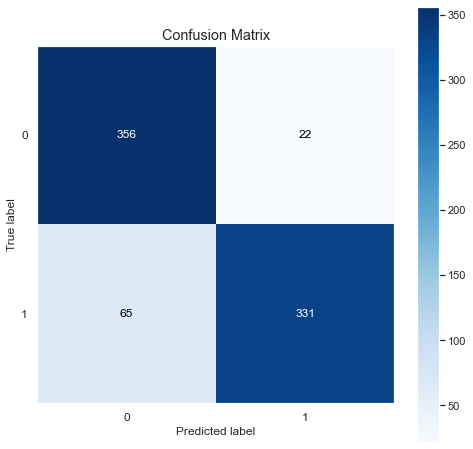

In [90]:
mt.plot_confusion_matrix(y_test, yhat_svm_tuned, normalize = False, figsize = (8,8))

# 9.0. STEP 09 - MODEL PERFORMANCE

In [105]:
X_test['Persistency_Flag'] = y_test
X_test['predictions'] = yhat_rf_tuned
X_test

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,Ntm_Speciality_Encoded,Persistency_Flag,predictions
790,3,0,0.000,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0.700,0.538,0.496,1,1
1735,0,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.000,0.322,0,0
2266,4,2,0.000,1,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0.400,0.462,0.377,0,1
1052,3,1,0.000,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0.100,0.462,0.322,0,0
443,0,1,2.000,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0.300,0.385,0.250,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536,1,1,0.000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.000,0.154,0.344,0,0
2073,4,1,0.000,1,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0.300,0.615,0.322,0,1
1419,3,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.322,0,0
3342,1,0,0.000,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0.400,0.154,0.496,0,0


## 9.1. Business Performance

### 9.1.1. Accuracy

Com a acucaria do modelo de ML e possivel descobrir a quatidade exata de previsoes acertadas pelo mesmo modelo.

In [120]:
df91 = pd.DataFrame({'Number_of_Values' : [X_test.shape[0]]})
df91['Accuracy'] = (result_rf_tuned['Accuracy']).astype(float64)
df91['Correct_Prediction'] = (np.round(df91['Number_of_Values'] * df91['Accuracy'])).astype(int64)

                            
df91

,Number_of_Values,Accuracy,Correct_Prediction
0,1028,0.809,832


De **1028** valores, o modelo de ML consguir fazer uma predicao correta do atributo 'Persistency_Flag' de **832** valores.

### 9.1.2. Confusion Matrix

Com a Matrix de confusao e possivel verificar quantos valores do atributo 'Persistency_Flag' foram classificados corretamente e erroneamente em cada classe, ou seja quantos valores igual a Persistent (1) e igual a Non-Presistent(0) foram classificados corretamente, e quantos de cada classe nao foram.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

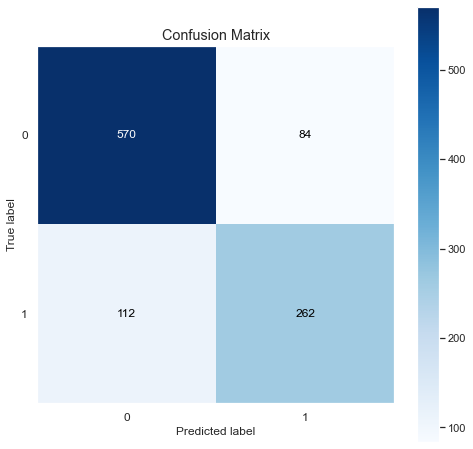

In [121]:
mt.plot_confusion_matrix(y_test, yhat_rf_tuned, normalize = False, figsize = (8,8))

Segundo a matrix de consfusao:

**570** valores que sao originalmente Non-Persistent (0) foram corretamente classiaficados como Non-Persistent;

**262** valores que sao originalmente Persistent (1) foram corretamente classiaficados como Persistent;

**84** valores que sao originalmente Non-Persistent (0) foram erroneamente classiaficados como Persistent;

**112** valores que sao originalmente Persistent (1) foram erroneamente classiaficados como Non-Persistent;

### 9.1.3. Precision

Atraves do metrica de avaliacao Precision, e possivel verificar quais valores do atributo 'Persistency_Flag' predicted/classified como Persistent (1) são realmente iguais a Persistent (1).

# 10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

In [105]:
# Save Training Model
pickle.dump(model_xgb_tuned, open('/Users/Igor/repos/Data-Science-Em-Producao/model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1. Rename Columns

        # changing column names
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        # function that changes column names to snakecase type
        snakecase = lambda x: inflection.underscore(x)

        # map maps the snakecase function to all words in the cols_old variable
        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date']) # changing the type of column date to datetime

        ## 1.5. Fillout NA using business logic
        # competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else
                                                                  x['competition_open_since_month'], axis =1)

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                                  x['competition_open_since_year'], axis =1)

        #promo2_since_week     
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else
                                                                  x['promo2_since_week'], axis =1)
        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                                  x['promo2_since_year'], axis =1)

        #promo_interval   
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True) 

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                               1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                                               0,axis = 1)

        ## 1.6. Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        
        return df1

    def feature_engineering(sel, df2):
        
        ## 2.4. Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since 
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                         month = x['competition_open_since_month'], 
                                                                         day = 1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(np.int64)

        # promo since 
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(np.int64)
      
        # assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic'    if x == 'a' else
                                                              'extra'    if x == 'b' else
                                                              'extended'                  )

        # state holiday 
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else
                                                                    'Easter holiday' if x == 'b' else
                                                                    'Christmas'      if x == 'c' else
                                                                    'regular_day'                     )

        # 3.0. STEP 03 - VARIABLES FILTER

        ## 3.1. Rows Filter

        ### Business restriction:
        df2 = df2[df2['open'] !=0]

        ## 3.2. Columns Selection

        ### Business restriction:
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        
        # 5.0. STEP 05 - DATA PREPARATION

        ## 5.2. Rescaling

        # competition_distance uses Robust Scaler
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # competition_time_month uses Robust Scaler
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
       
        # promo_time_week uses Min-Max Scaler
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year uses Min-Max Scaler
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. TRansformation

        ### 5.3.1. Encoding

        # variaveis categoricas

        # state_holiday
        df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

        # store_type
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment
        assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.2 Nature Rtansformation

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))) 
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7))) 
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))) 
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))) 
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance',
             'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
             'competition_time_month', 'promo_time_week', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
             'month_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data) # test_data are data preperad
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')  

## 10.2. API Handler # so roda em IDE

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/Users/Igor/repos/Data-Science-Em-Producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST']) # endpoint, where the original data with the forecast will be sent
def rossmann_predict():
    test_json = request.get_json() # here pulls up the original csv files for both train and store
  
    if test_json: # there is data
          # json to dataframe conversion
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index =[0])
            
        else: # Multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # instantiate Rossmann class # get the information from rossmann class
        pipeline = Rossmann()
        
        # data cleaning # model preparation 1
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering # model preparation 2 
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation # model preparation 3
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)# test raw is the original data and df3 is the prepared data

       
        return df_response
    
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    app.run('127.0.0.1')

## 10.3. API Tester

In [106]:
import requests

In [107]:
# loading test dataset
df10 = pd.read_csv('/Users/Igor/repos/Data-Science-Em-Producao/data/test.csv')
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [108]:
#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction
#df_test = df_test[df_test['Store'] == 22]
df_test = df_test[df_test['Store'].isin([733, 1097, 742, 562, 1089])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Store'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [111]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [119]:
# API Call
url = 'https://rosmann-prediction-model.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [113]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [114]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,562,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,b,extended,1210.000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,7088.359
1,733,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,b,extra,860.000,...,2015,9,17,38,2015-37,1999-10-01T00:00:00.000Z,194,2015-09-14T00:00:00.000Z,0,7396.790
2,742,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,d,extended,4380.000,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,8296.562
3,1089,4,2015-09-17T00:00:00.000Z,1.000,1,regular_day,0,d,basic,5220.000,...,2015,9,17,38,2015-37,2009-05-01T00:00:00.000Z,77,2015-09-14T00:00:00.000Z,0,9627.442
4,562,3,2015-09-16T00:00:00.000Z,1.000,1,regular_day,0,b,extended,1210.000,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2015-09-14T00:00:00.000Z,0,7198.647


In [115]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
d2

,store,prediction
0,562,337632.528
1,733,315717.767
2,742,356501.403
3,1089,370394.611
4,1097,255904.538


In [116]:
for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i, 'prediction']))

Store Number 562 will sell $337,632.53 in the next 6 weeks
Store Number 733 will sell $315,717.77 in the next 6 weeks
Store Number 742 will sell $356,501.40 in the next 6 weeks
Store Number 1089 will sell $370,394.61 in the next 6 weeks
Store Number 1097 will sell $255,904.54 in the next 6 weeks
